In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [18]:
def duration_to_seconds(duration_str):
    duration = pd.to_timedelta(duration_str)
    return duration.total_seconds()

In [19]:
def preprocess_data(X):
    X = X.copy()
    
    # Convert date columns to numerical features
    X['deadline_weekday'] = X['deadline'].dt.strftime('%w').astype(int)
    X['deadline_month'] = X['deadline'].dt.month
    X['deadline_day'] = X['deadline'].dt.day
    X['deadline_year'] = X['deadline'].dt.year
    X['deadline_hour'] = X['deadline'].dt.hour
    print(X['deadline_weekday'])

    # Convert boolean columns to int
    bool_columns = ['staff_pick', 'spotlight']
    X[bool_columns] = X[bool_columns].astype(int)

    # Get dummy variables for categorical columns
    categorical_columns = ['state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday']
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

    
    # Convert datetime columns to duration in seconds
    datetime_columns = ['create_to_launch', 'launch_to_deadline', 'launch_to_state_change']
    print("Before conversion to seconds:")
    print(X[datetime_columns].head())
    for col in datetime_columns:
        X[f"{col}_seconds"] = X[col].apply(duration_to_seconds)

    # After the operation
    print("\nAfter conversion to seconds:")
    print(X[[f"{col}_seconds" for col in datetime_columns]].head())

    # Drop the original datetime columns
    X = X.drop(datetime_columns + ['deadline'], axis=1)

    return X


In [20]:
# Load the dataset
data = pd.read_csv("kickstarter_data_full.csv", low_memory=False)

columns_to_drop = ['id', 'photo', 'name', 'blurb', 'slug', 'disable_communication', 'currency_symbol',
                   'currency_trailing_code', 'state_changed_at', 'created_at', 'launched_at', 'creator',
                   'location', 'profile', 'urls', 'source_url', 'friends', 'is_starred', 'is_backing', 'permissions']

data_cleaned = data.drop(columns=columns_to_drop)

date_columns = ['deadline']

print(data["deadline"])


0        2015-01-23 10:35:00
1        2015-05-01 16:13:22
2        2015-03-26 08:17:04
3        2014-10-06 00:41:17
4        2016-06-27 12:00:00
                ...         
20627    2016-01-10 16:59:00
20628    2017-01-05 11:41:36
20629    2015-04-14 12:08:00
20630    2015-05-20 13:36:59
20631    2014-11-20 04:24:14
Name: deadline, Length: 20632, dtype: object


In [21]:
#Convert deadline column from object data type to datetime64
for col in date_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col])

print(data_cleaned["deadline"])

0       2015-01-23 10:35:00
1       2015-05-01 16:13:22
2       2015-03-26 08:17:04
3       2014-10-06 00:41:17
4       2016-06-27 12:00:00
                ...        
20627   2016-01-10 16:59:00
20628   2017-01-05 11:41:36
20629   2015-04-14 12:08:00
20630   2015-05-20 13:36:59
20631   2014-11-20 04:24:14
Name: deadline, Length: 20632, dtype: datetime64[ns]


In [22]:
missing_categories = data_cleaned['category'].isna().sum()
total_rows = len(data_cleaned)
percentage_missing = (missing_categories / total_rows) * 100
print(f"Percentage of missing values in the 'category' column: {percentage_missing:.2f}%")

Percentage of missing values in the 'category' column: 9.16%


In [23]:
# create boolean mask indicating cells with missing values
mask = data_cleaned.isnull()

# use any() method to determine which columns have at least one missing value
missing_cols = data_cleaned.columns[mask.any()]

# print the columns with missing values
print(missing_cols)


Index(['category', 'name_len', 'name_len_clean', 'blurb_len',
       'blurb_len_clean'],
      dtype='object')


In [24]:
# count the missing values for each column
missing_counts = data_cleaned.isnull().sum()

# print the counts of missing values for each column
print(missing_counts[missing_counts > 0])


category           1889
name_len              5
name_len_clean        5
blurb_len             5
blurb_len_clean       5
dtype: int64


In [25]:
#Filling missing value with unknown
data_cleaned['category'].fillna('Unknown', inplace=True)
mean_columns = ['name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean']

#Filling missing spaces with mean value
for col in mean_columns:
    data_cleaned[col].fillna(data_cleaned[col].mean(), inplace=True)

In [26]:
# select columns with object or categorical data types
categorical_cols = data_cleaned.select_dtypes(include=['object', 'category']).columns

# print the list of categorical columns
print(categorical_cols)

Index(['state', 'country', 'currency', 'category', 'deadline_weekday',
       'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday',
       'create_to_launch', 'launch_to_deadline', 'launch_to_state_change'],
      dtype='object')


In [27]:
print("Before One Hot Encoding:")
print(data_cleaned[['country', 'category', 'currency']].head())

data_cleaned = pd.get_dummies(data_cleaned, columns=['country', 'category', 'currency'], drop_first=True)

# After One Hot Encoding
print("\nAfter One Hot Encoding:")

# Get columns that originated from 'country'
country_columns = [col for col in data_cleaned.columns if col.startswith('country_')]
print("\nCountry Columns:")
print(country_columns)

# Get columns that originated from 'category'
category_columns = [col for col in data_cleaned.columns if col.startswith('category_')]
print("\nCategory Columns:")
print(category_columns)

# Get columns that originated from 'currency'
currency_columns = [col for col in data_cleaned.columns if col.startswith('currency_')]
print("\nCurrency Columns:")
print(currency_columns)








Before One Hot Encoding:
  country  category currency
0      US  Academic      USD
1      US  Academic      USD
2      US  Academic      USD
3      US  Academic      USD
4      DE  Academic      EUR

After One Hot Encoding:

Country Columns:
['country_AU', 'country_BE', 'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US']

Category Columns:
['category_Apps', 'category_Blues', 'category_Comedy', 'category_Experimental', 'category_Festivals', 'category_Flight', 'category_Gadgets', 'category_Hardware', 'category_Immersive', 'category_Makerspaces', 'category_Musical', 'category_Places', 'category_Plays', 'category_Restaurants', 'category_Robots', 'category_Shorts', 'category_Software', 'category_Sound', 'category_Spaces', 'category_Thrillers', 'category_Unknown', 'category_Wearables', 'category

In [28]:
# # Check the correlation between features
# corr_matrix = data_cleaned.corr()
# sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
# plt.show()

In [29]:
X = data_cleaned.drop('state', axis=1)
y = data_cleaned['state']

In [30]:
le = LabelEncoder()
y = le.fit_transform(y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Preprocess the training and test sets
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

6244     3
9380     1
6105     5
15825    1
19026    0
        ..
11284    5
11964    4
5390     6
860      3
15795    0
Name: deadline_weekday, Length: 16505, dtype: int64
Before conversion to seconds:
                  create_to_launch          launch_to_deadline  \
6244     3 days 00:20:38.000000000  30 days 00:00:00.000000000   
9380     1 days 06:01:55.000000000  31 days 00:00:00.000000000   
6105     1 days 13:54:47.000000000  28 days 10:54:29.000000000   
15825  104 days 04:24:18.000000000  35 days 00:00:00.000000000   
19026   28 days 20:57:01.000000000  45 days 00:00:00.000000000   

           launch_to_state_change  
6244   30 days 00:00:00.000000000  
9380   31 days 00:00:00.000000000  
6105   28 days 10:54:29.000000000  
15825   0 days 00:00:01.000000000  
19026  45 days 00:00:00.000000000  

After conversion to seconds:
       create_to_launch_seconds  launch_to_deadline_seconds  \
6244                   260438.0                   2592000.0   
9380                   10811

/var/folders/lx/xmx3rkvn0f71ry2n4cf0b9880000gn/T/ipykernel_64384/3246413450.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


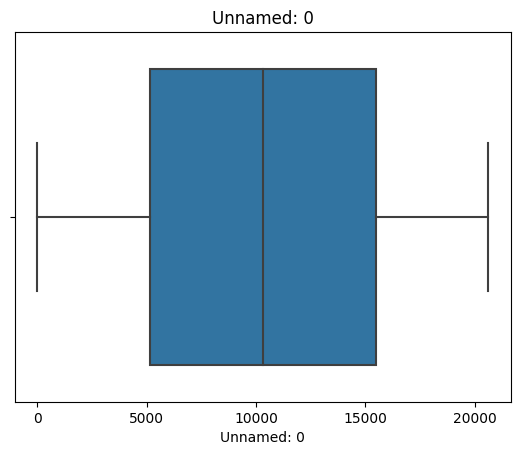

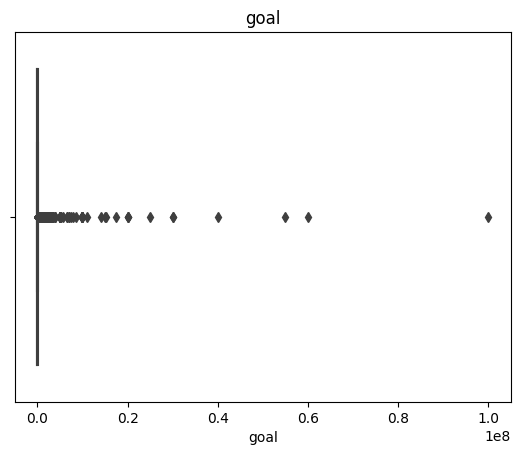

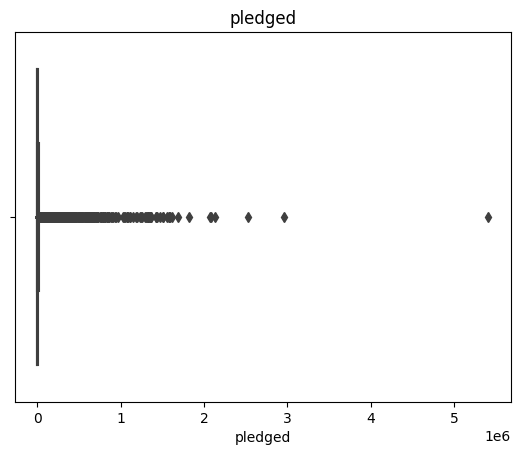

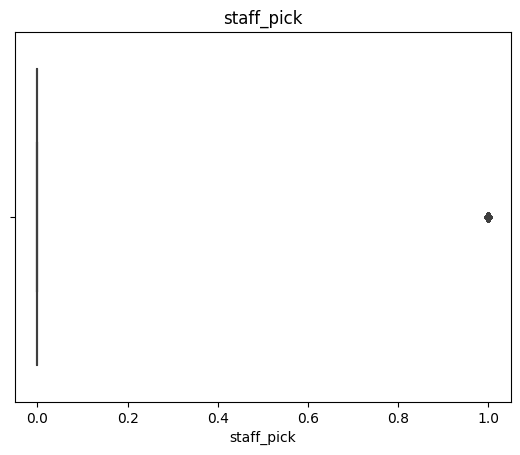

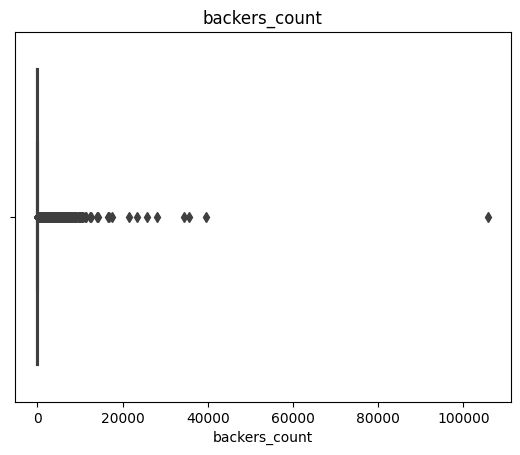

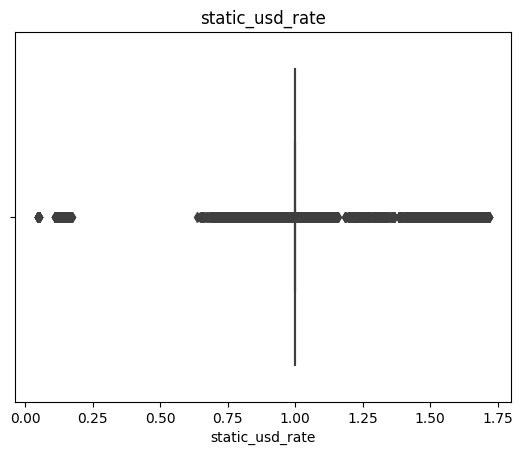

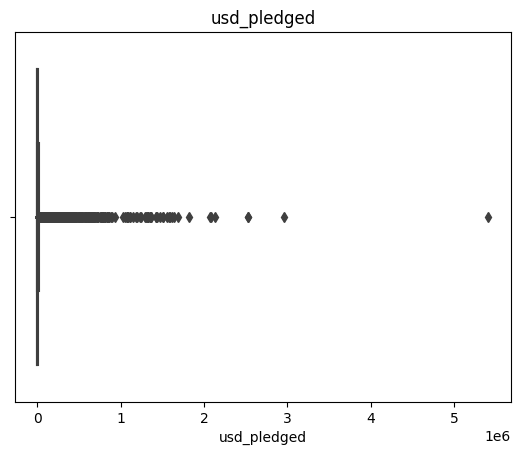

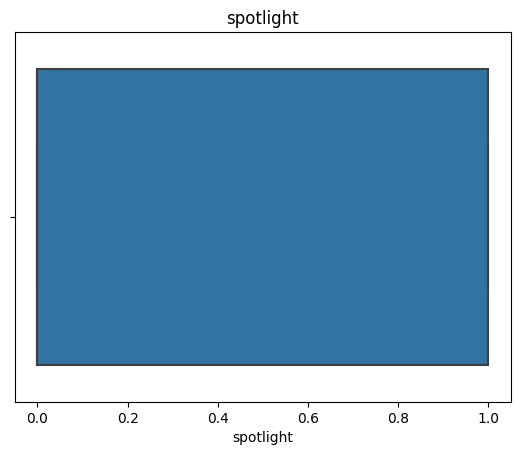

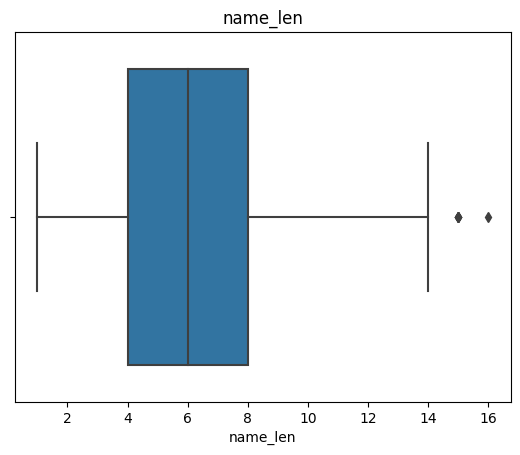

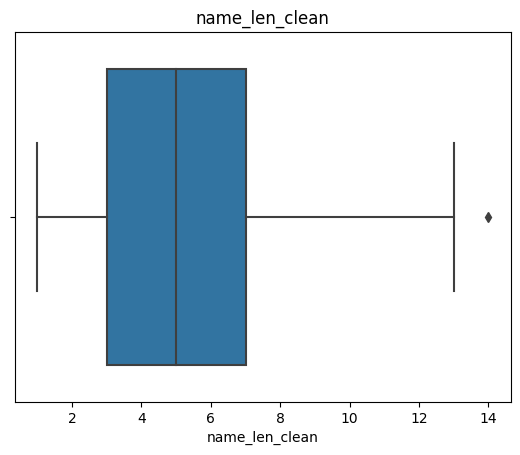

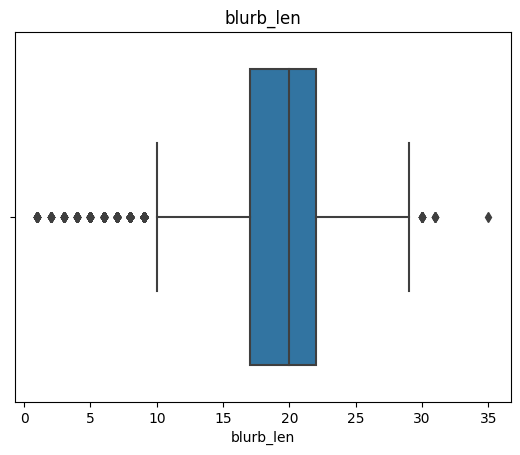

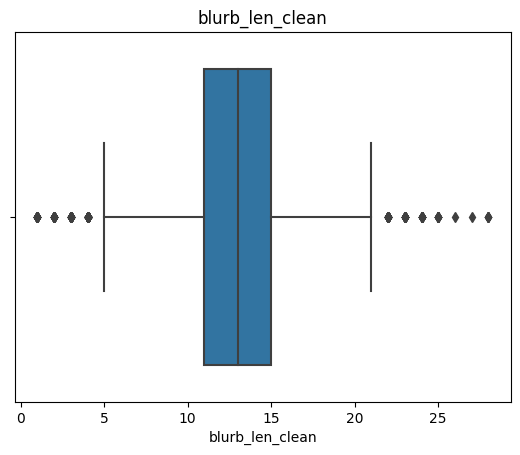

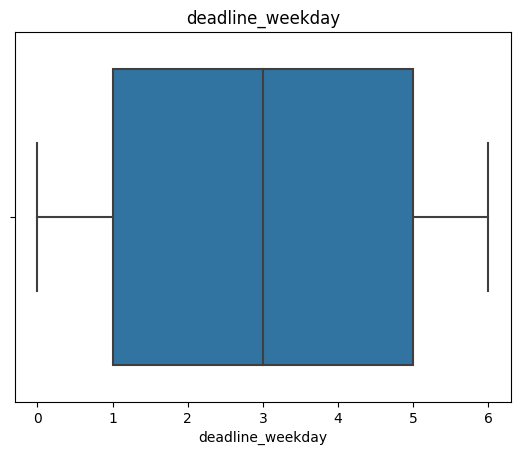

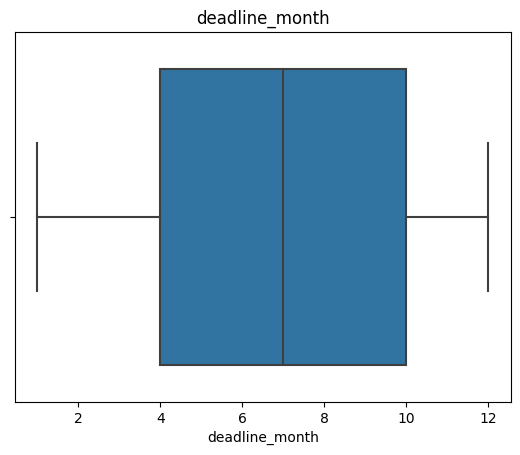

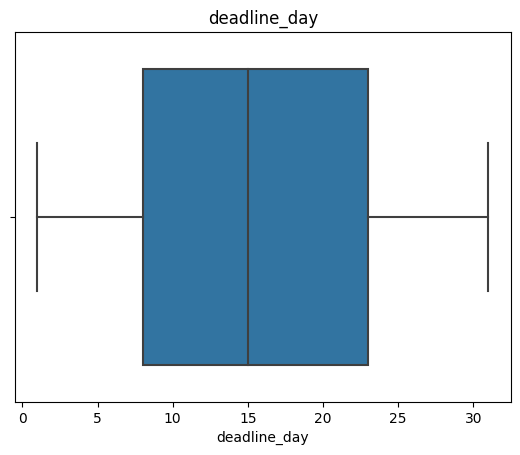

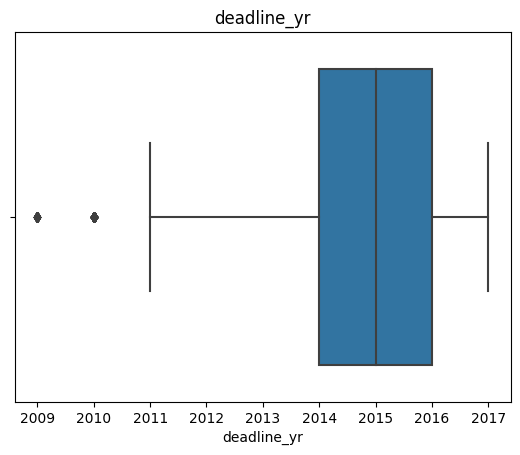

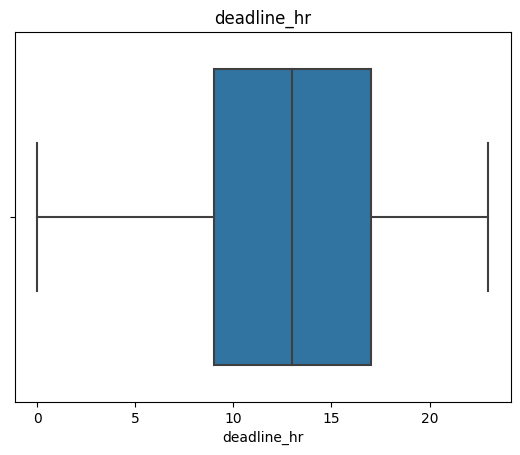

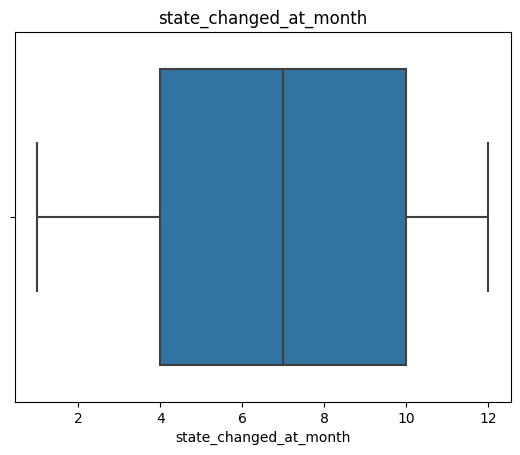

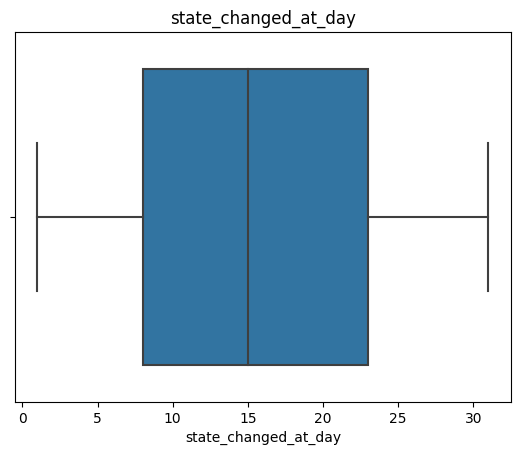

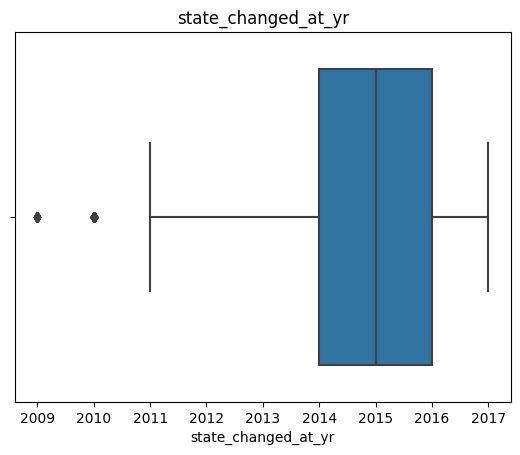

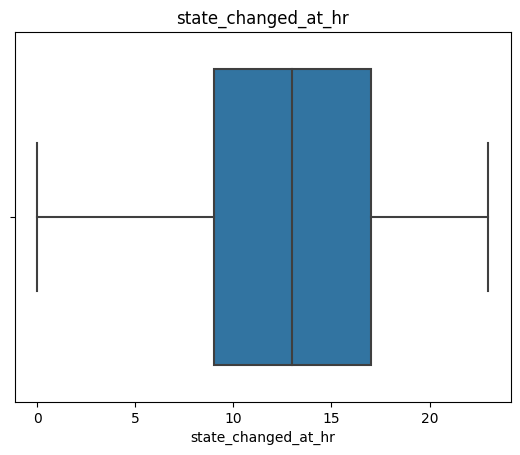

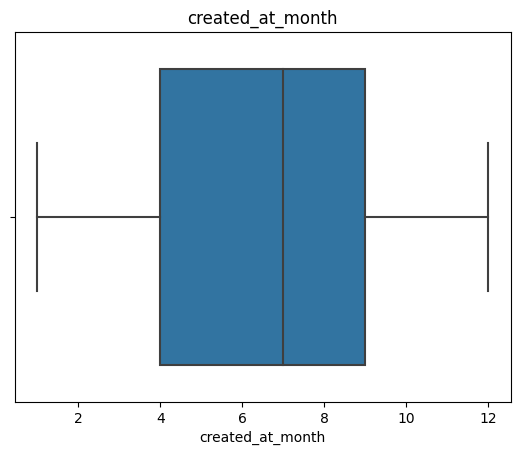

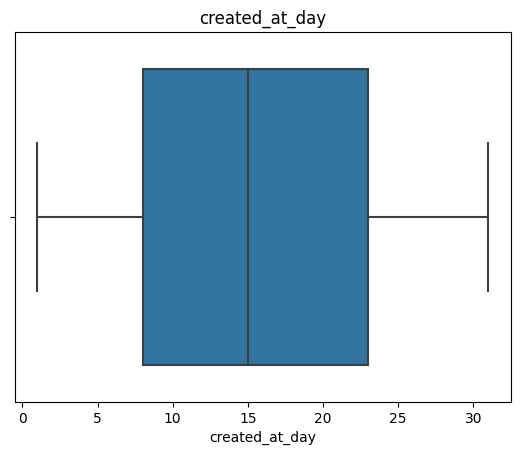

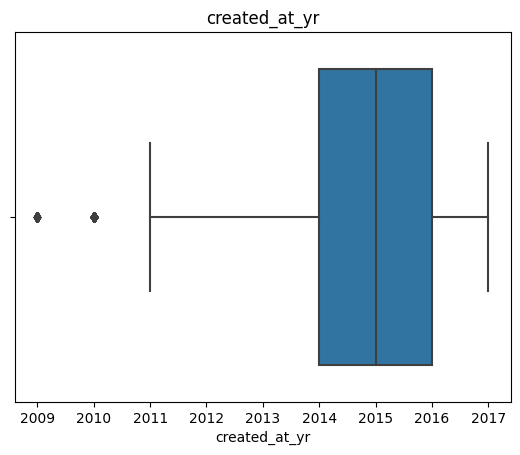

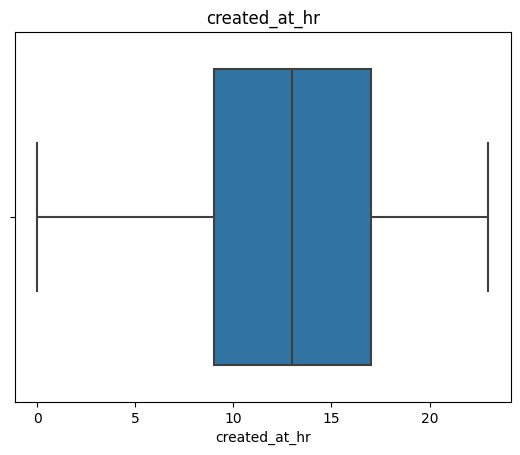

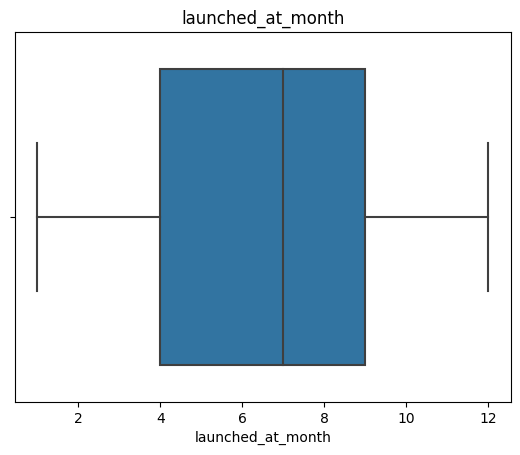

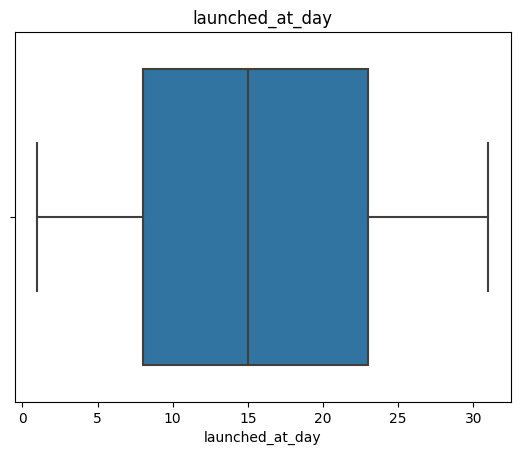

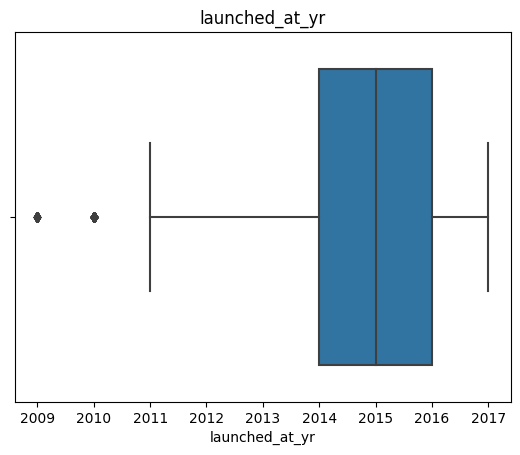

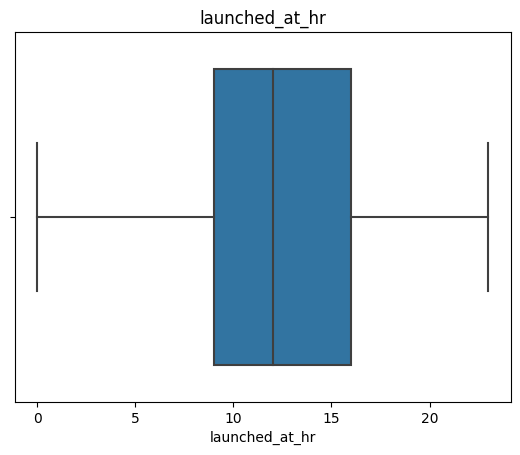

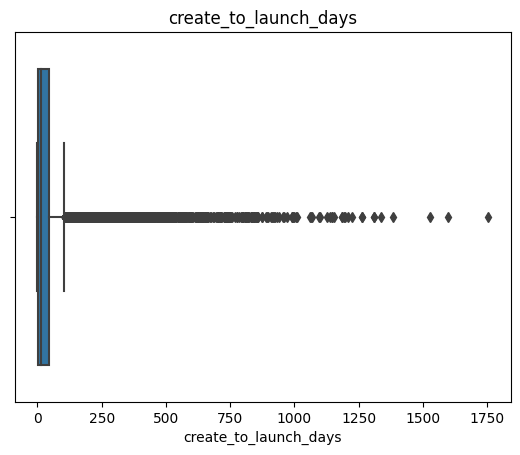

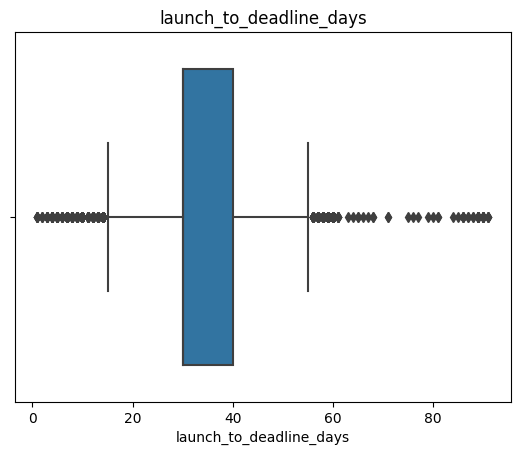

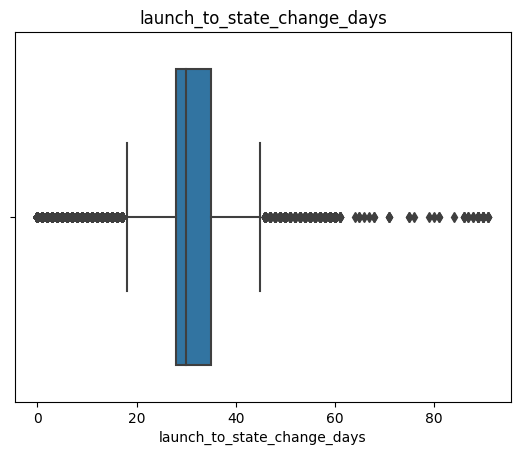

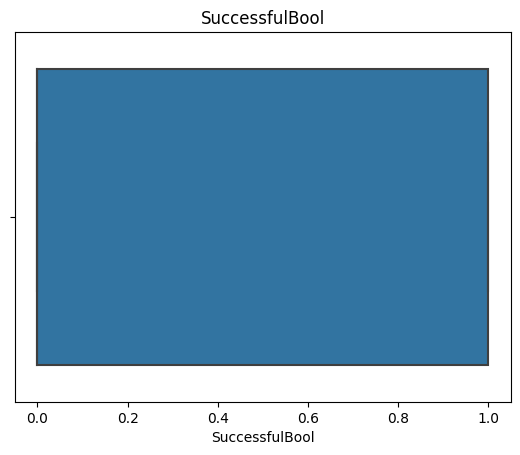

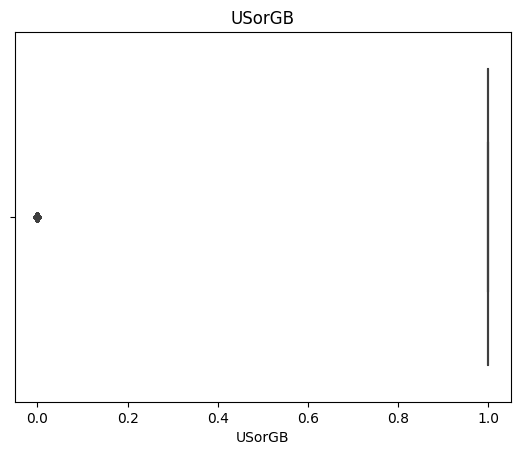

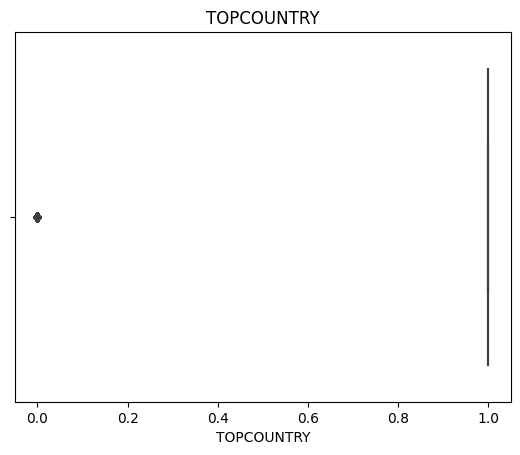

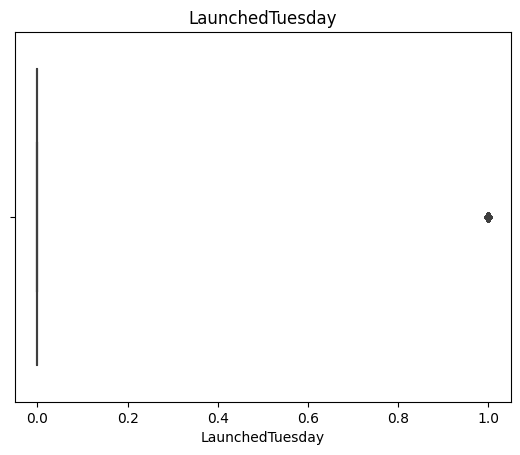

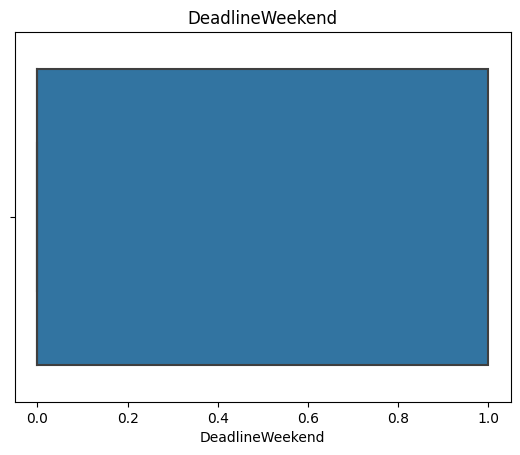

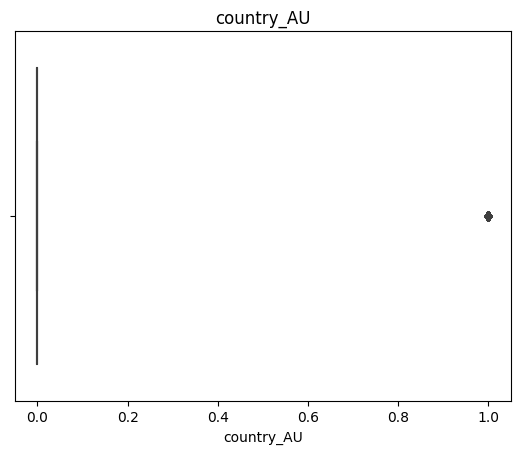

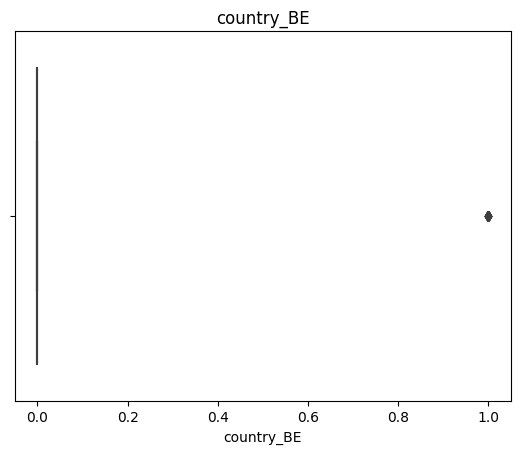

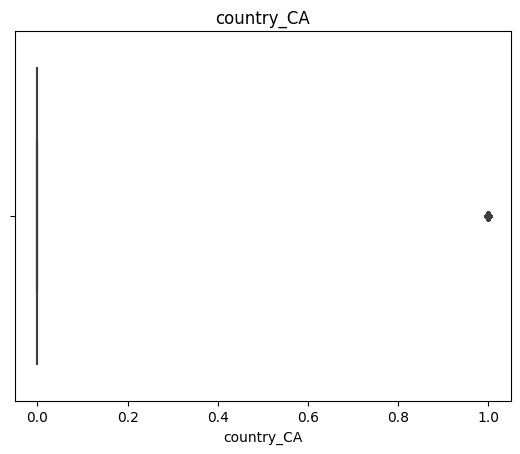

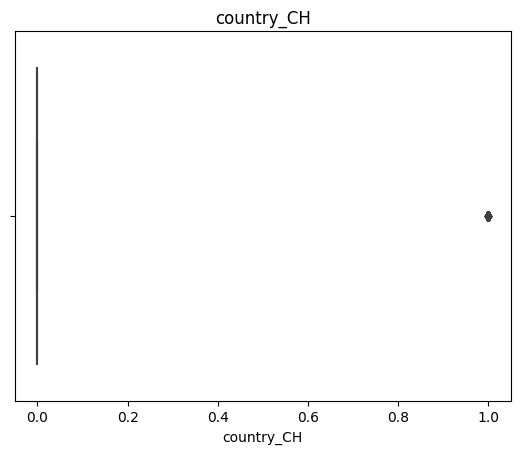

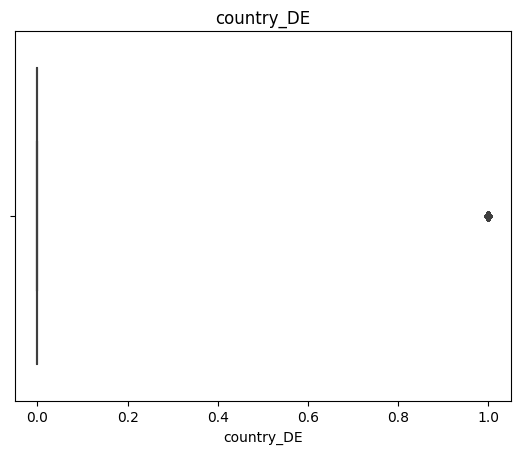

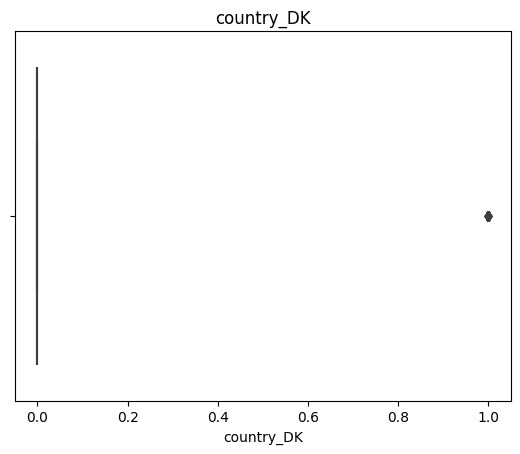

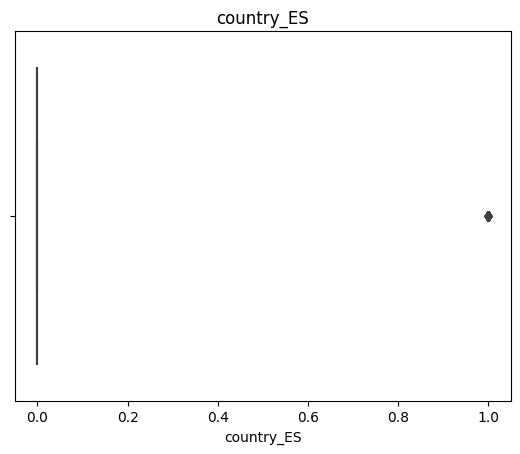

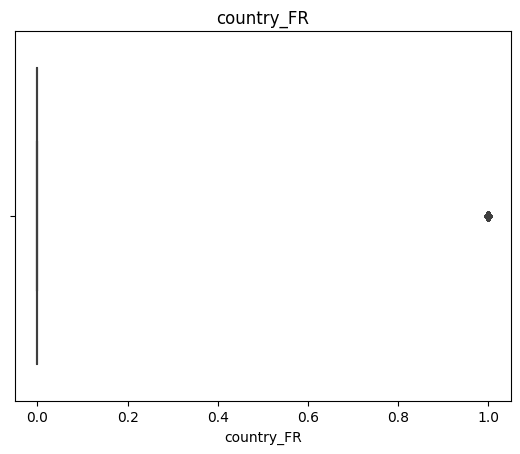

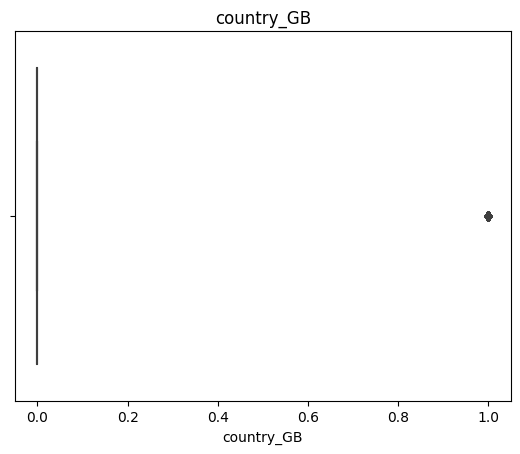

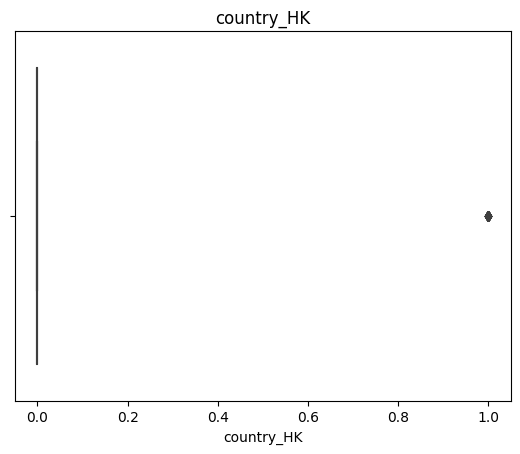

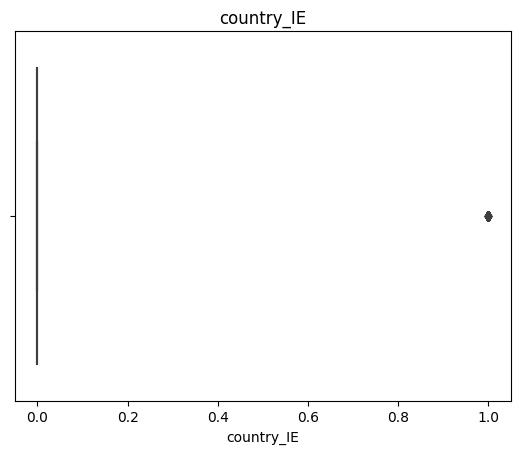

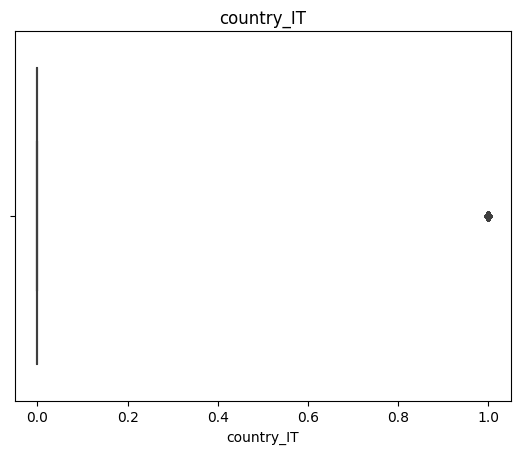

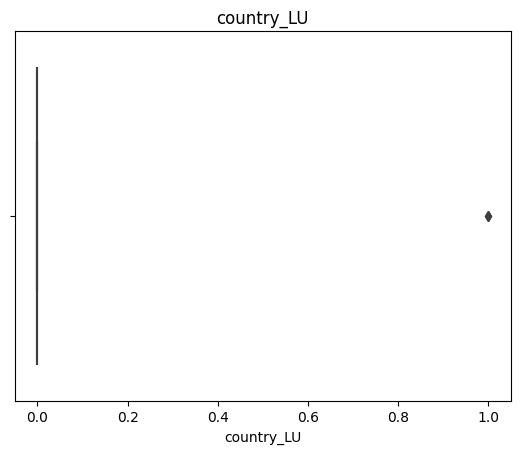

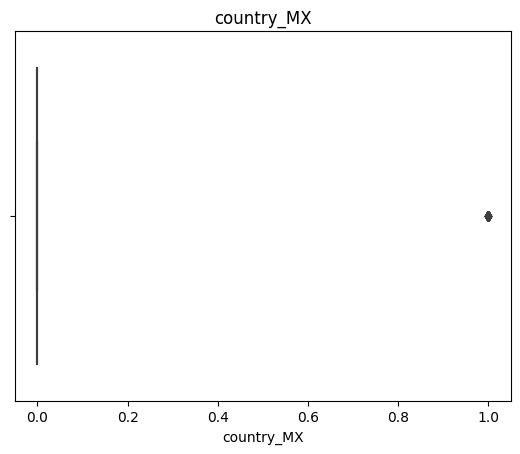

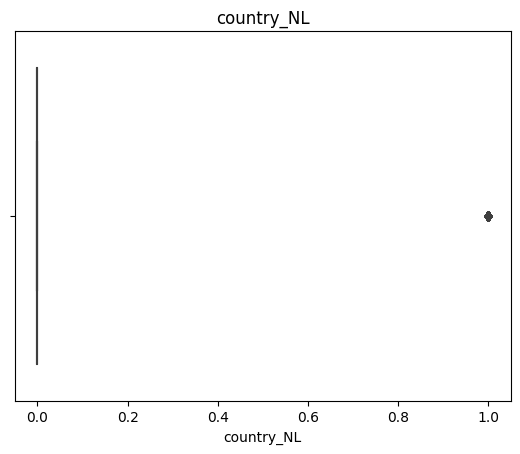

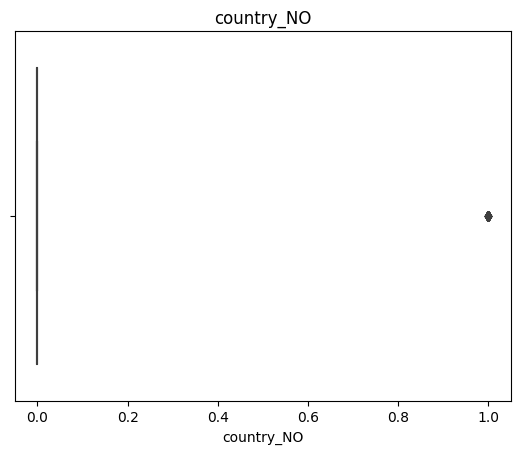

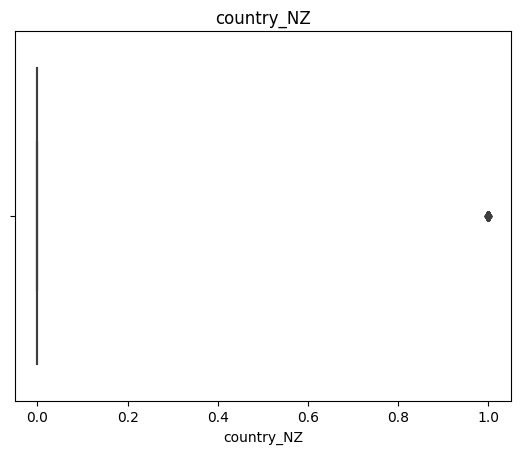

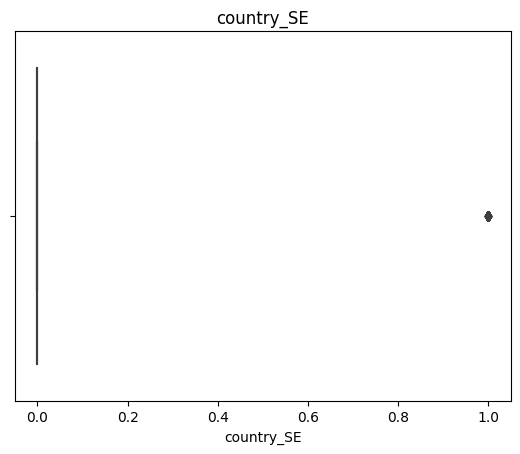

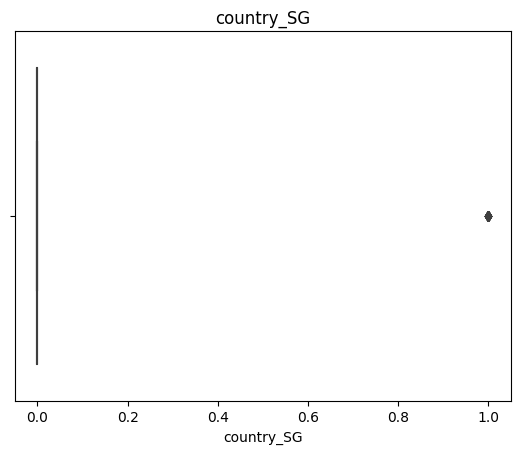

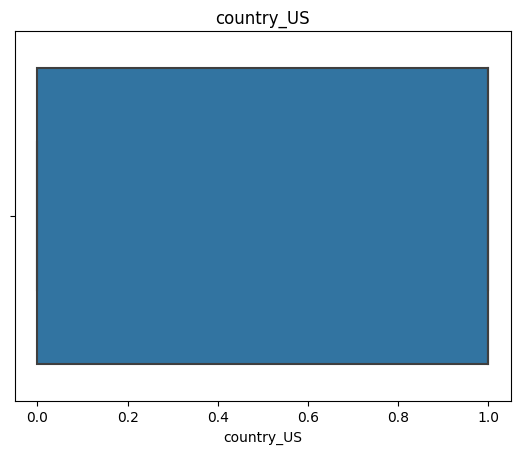

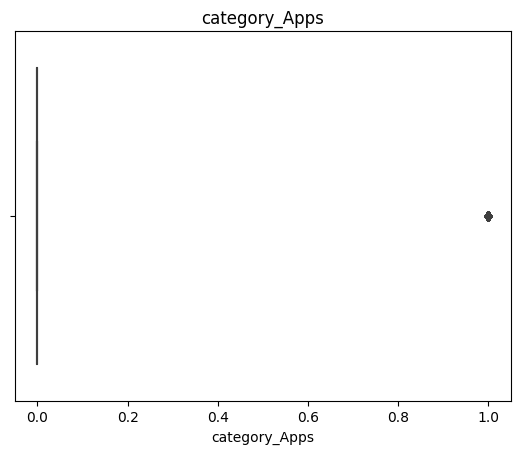

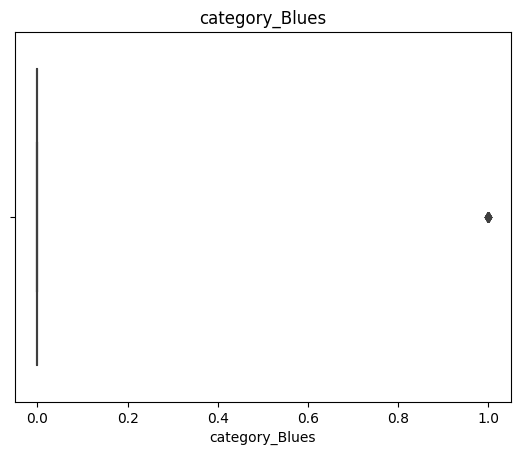

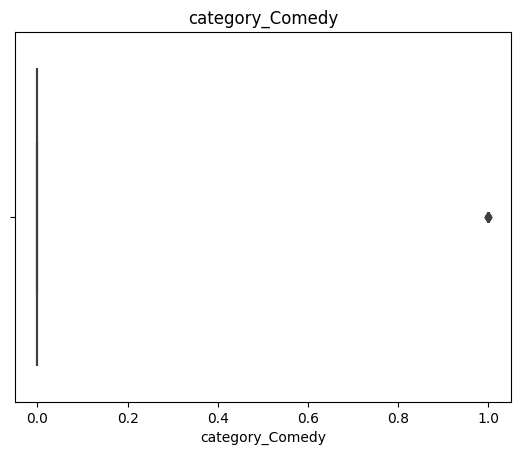

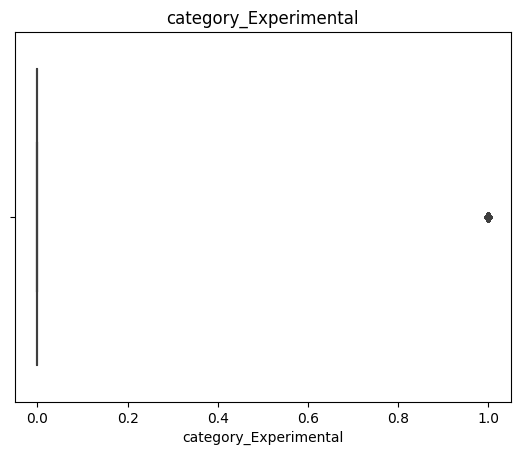

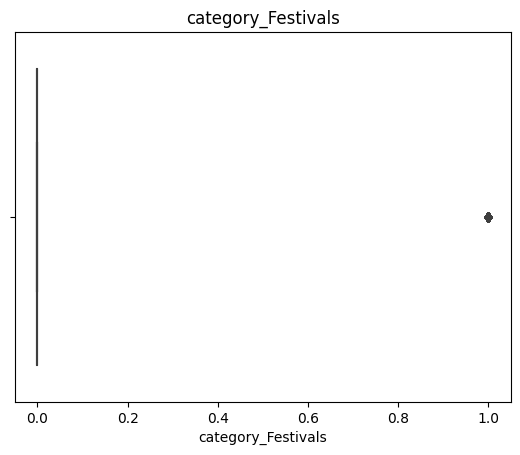

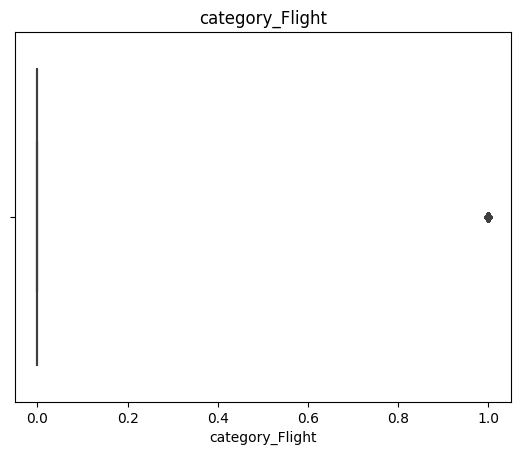

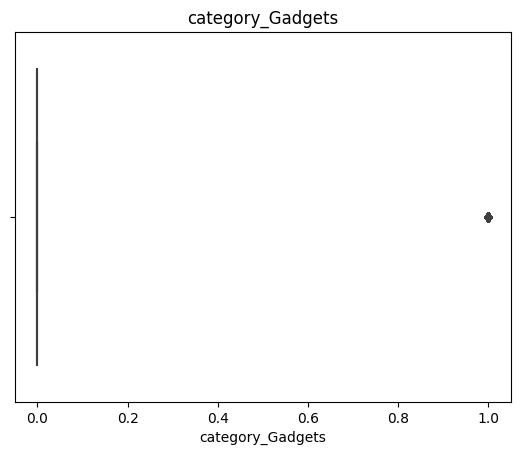

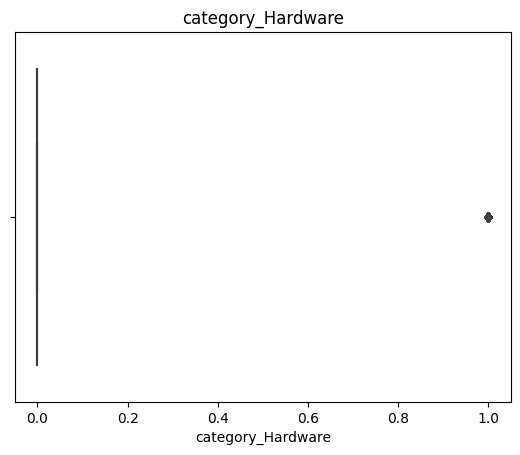

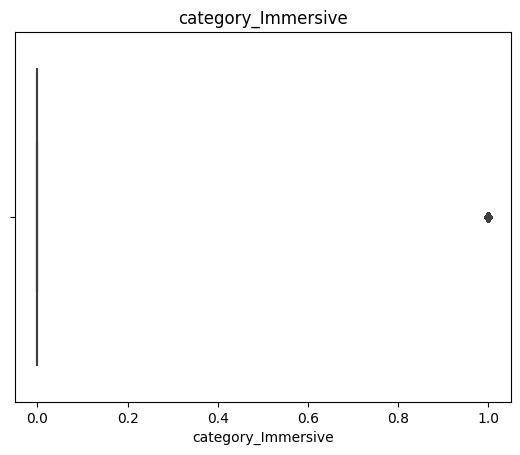

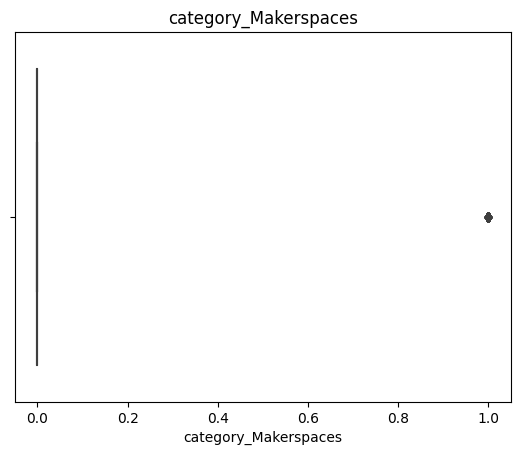

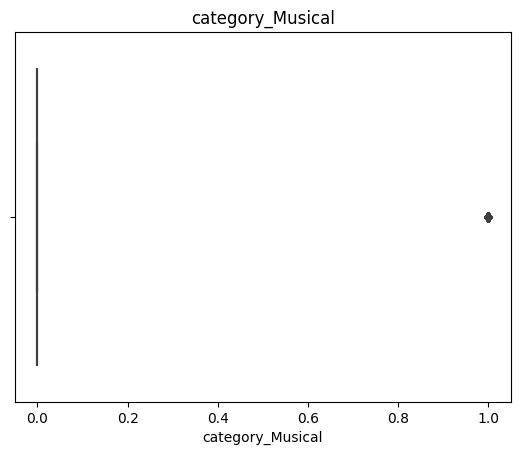

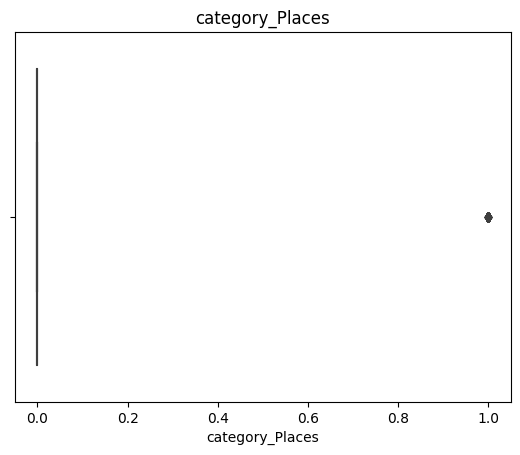

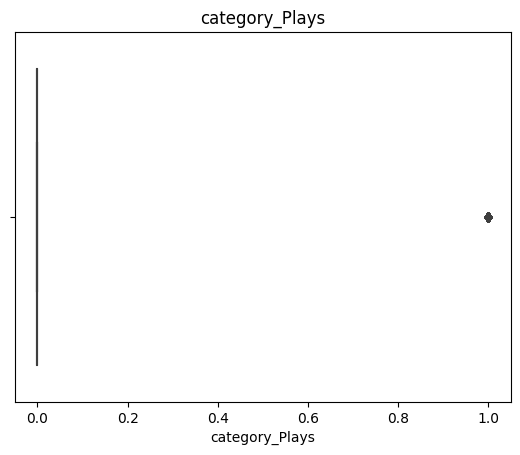

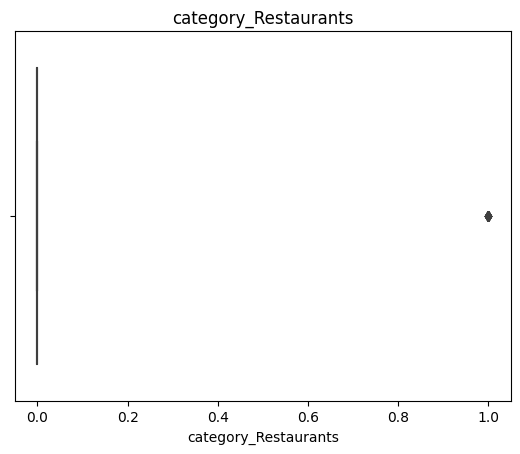

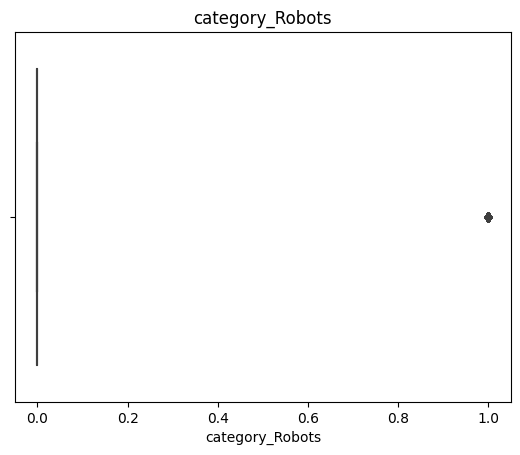

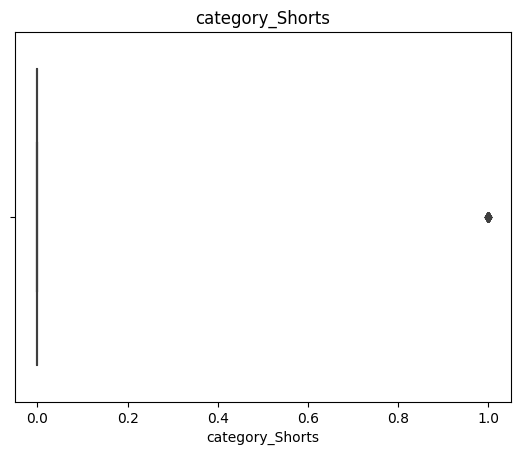

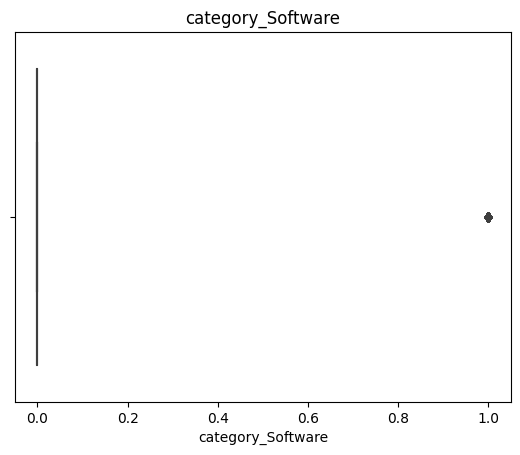

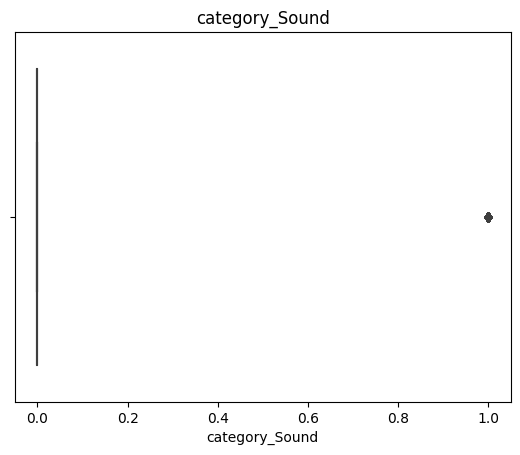

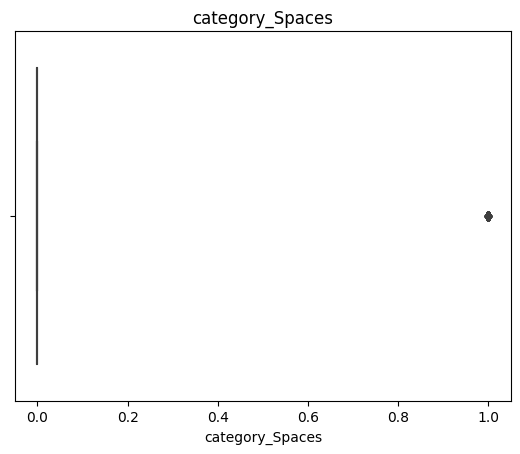

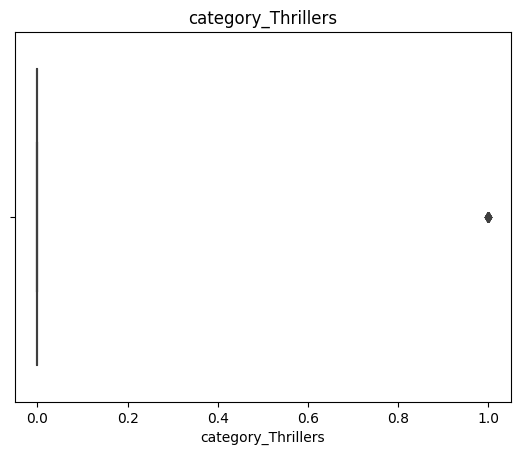

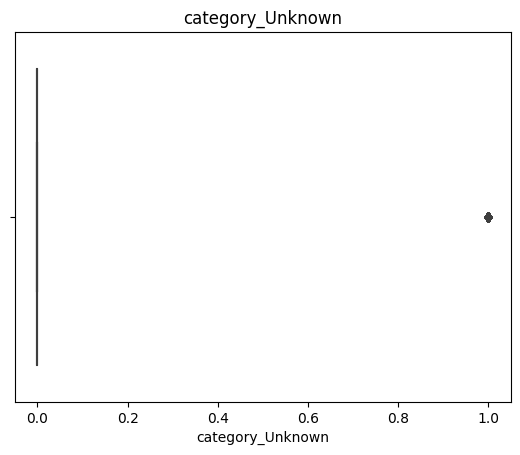

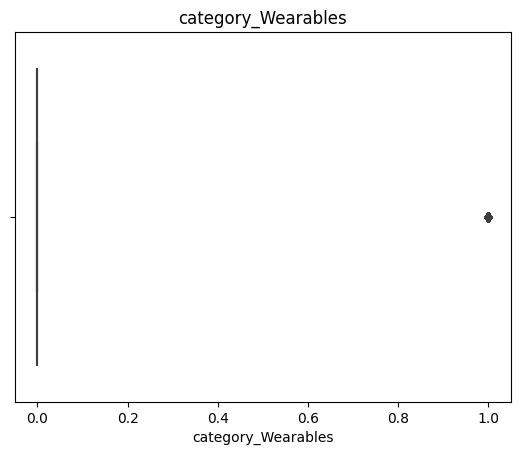

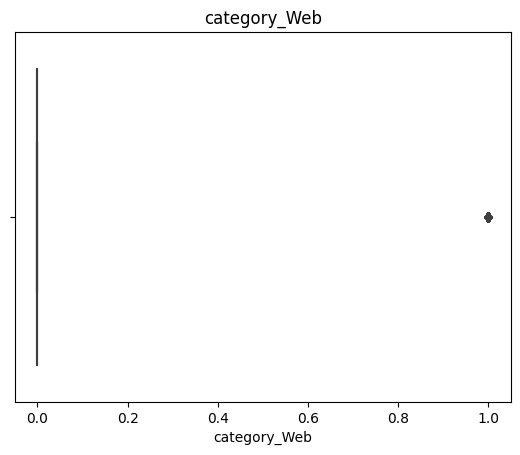

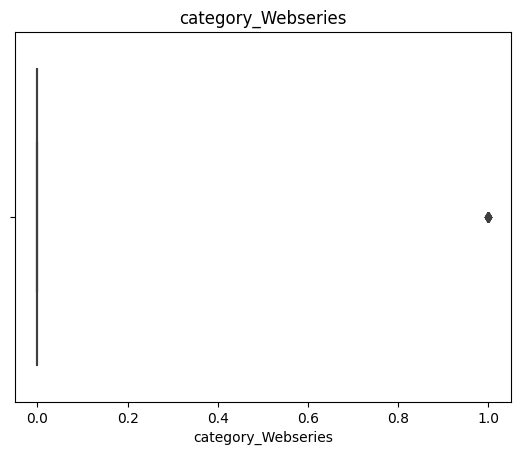

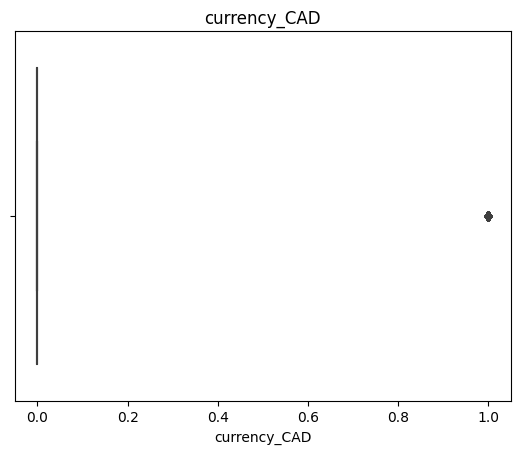

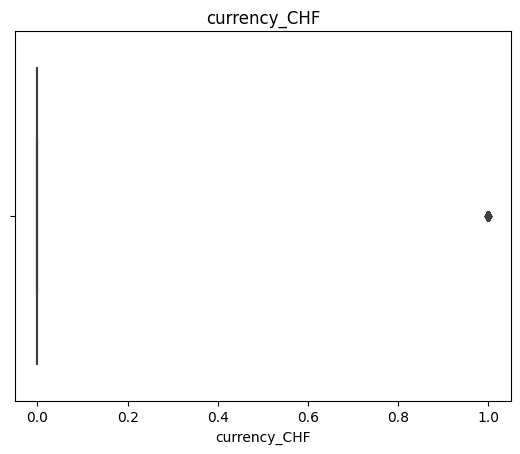

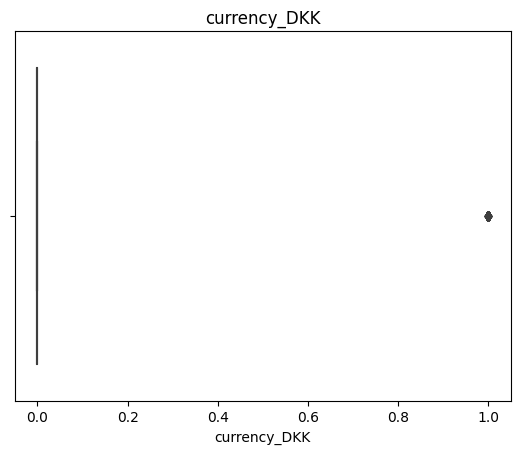

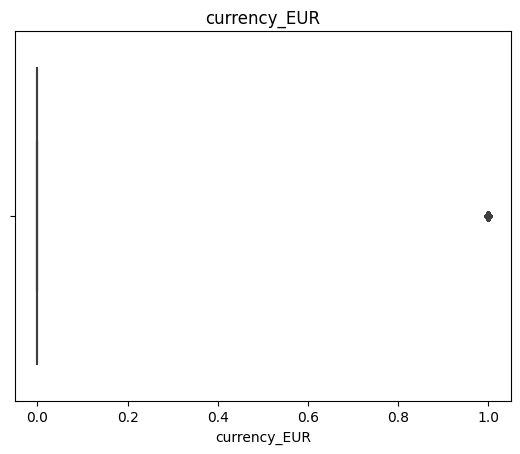

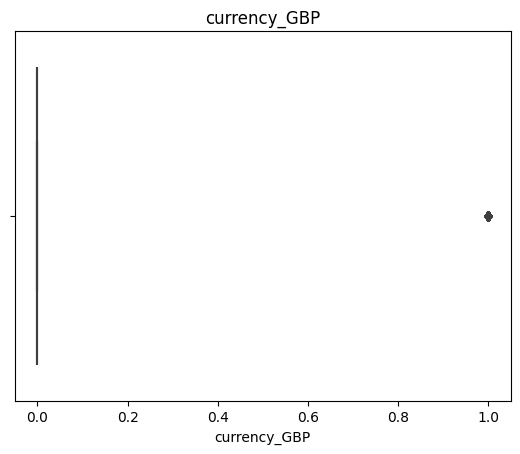

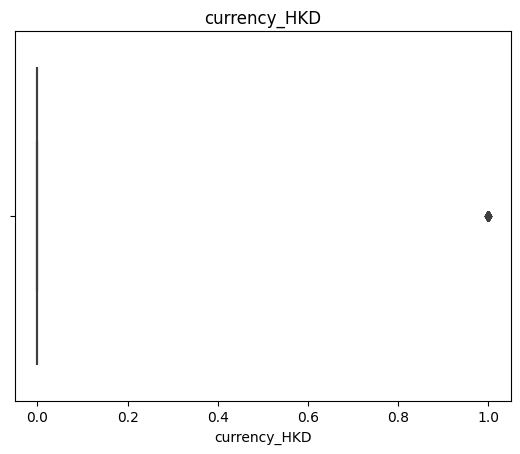

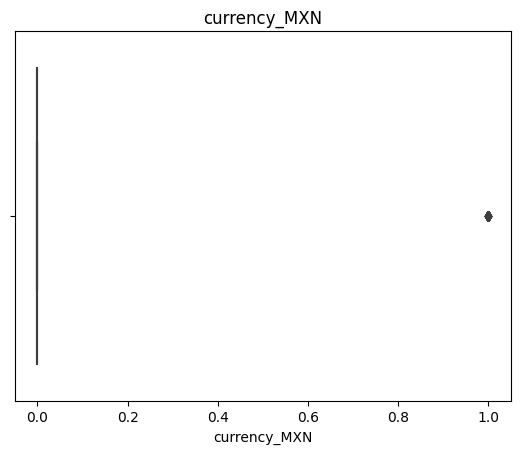

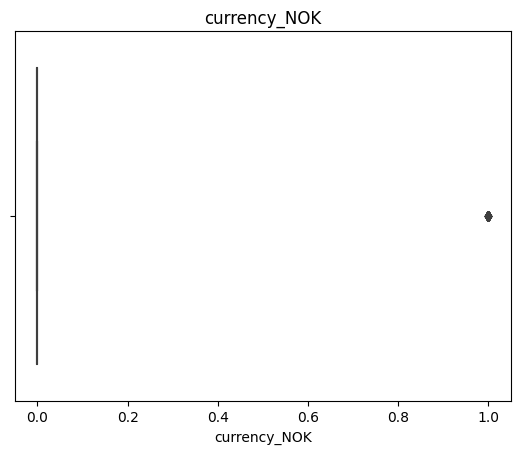

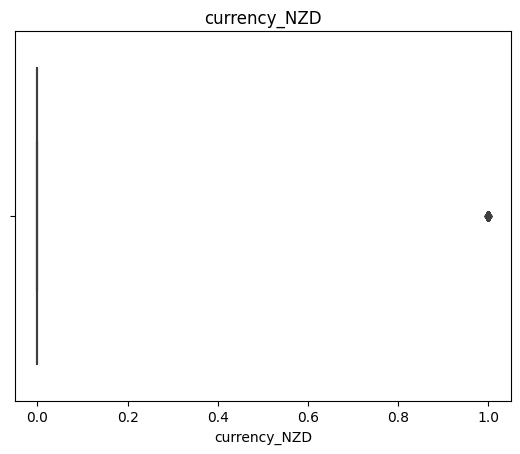

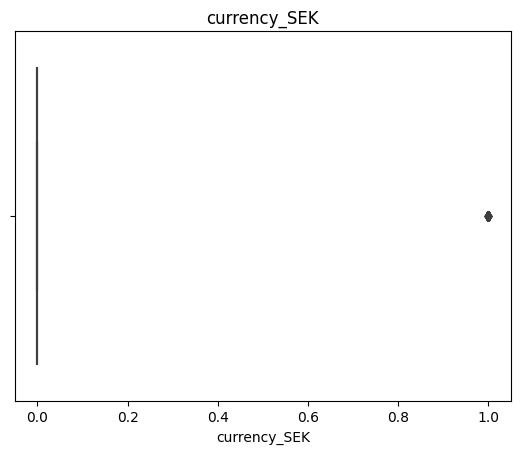

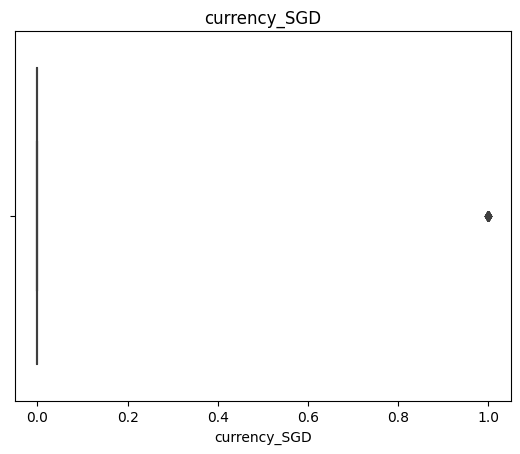

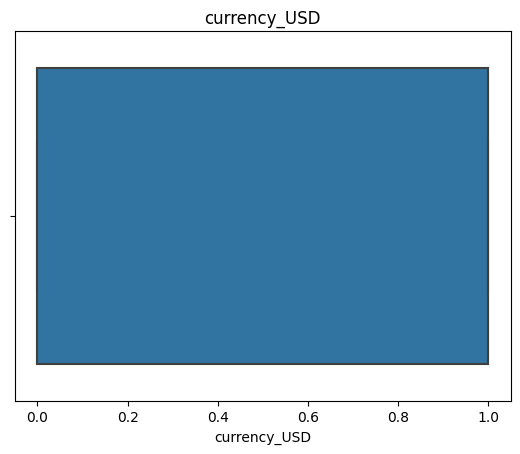

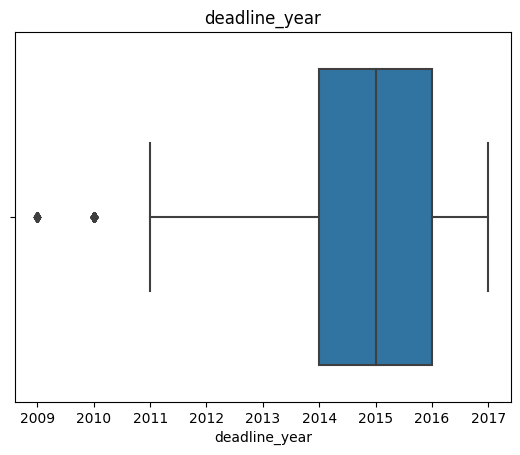

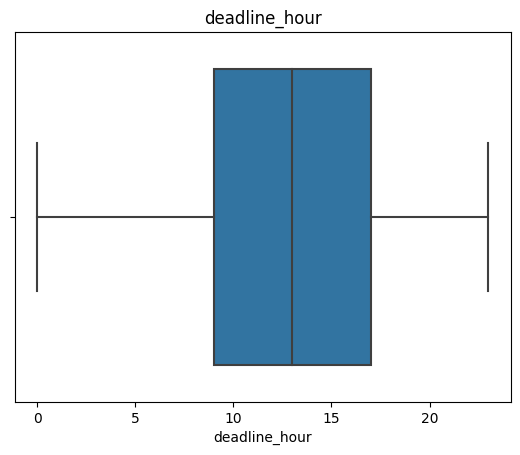

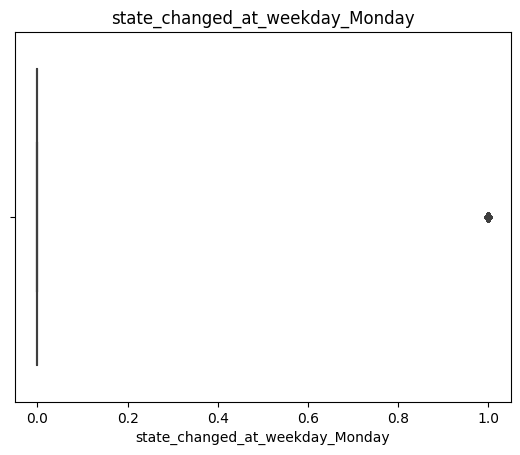

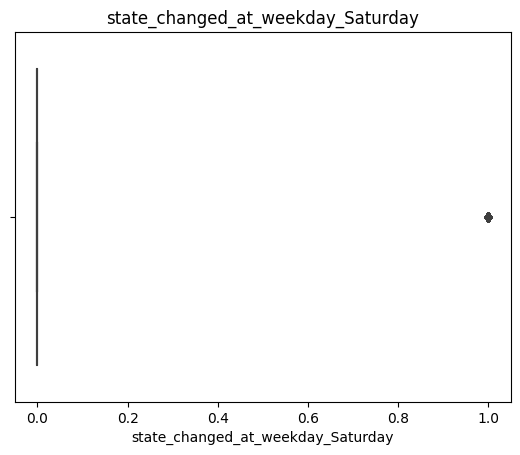

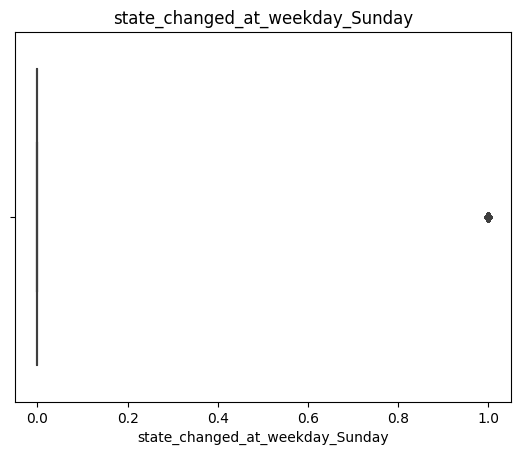

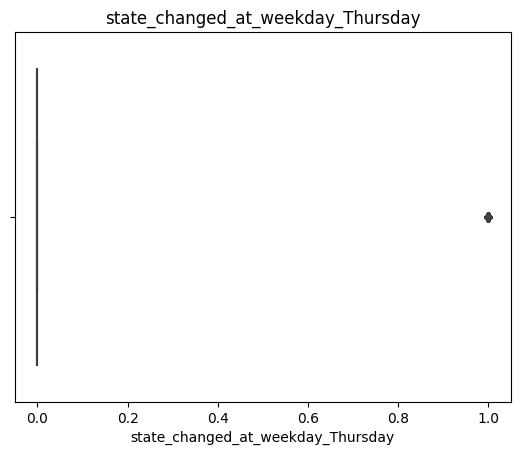

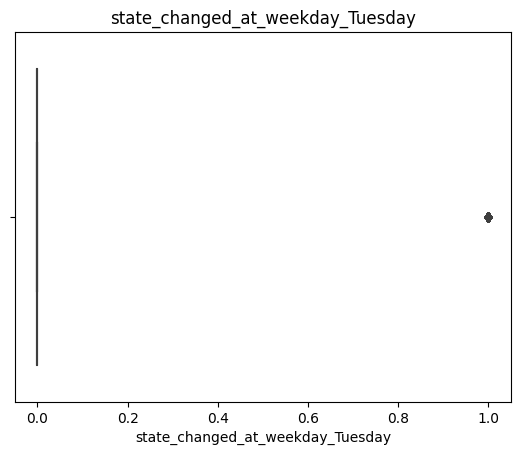

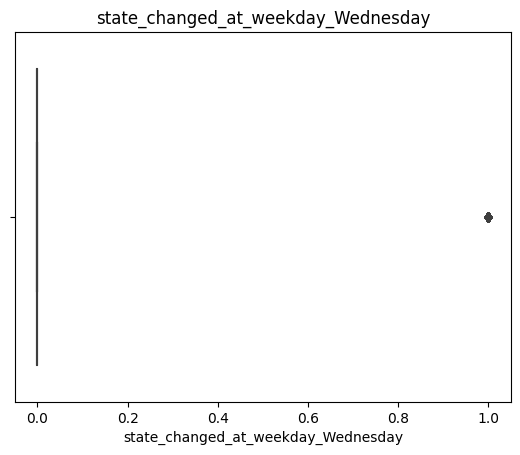

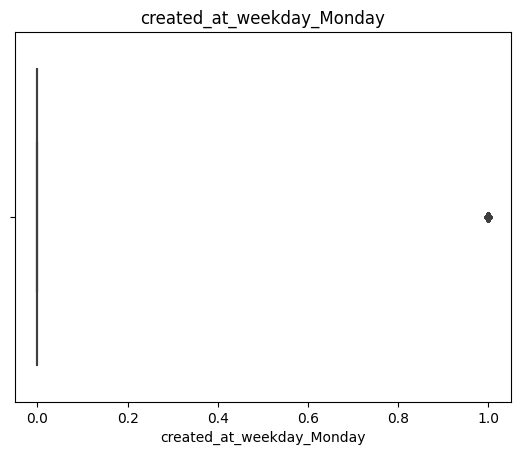

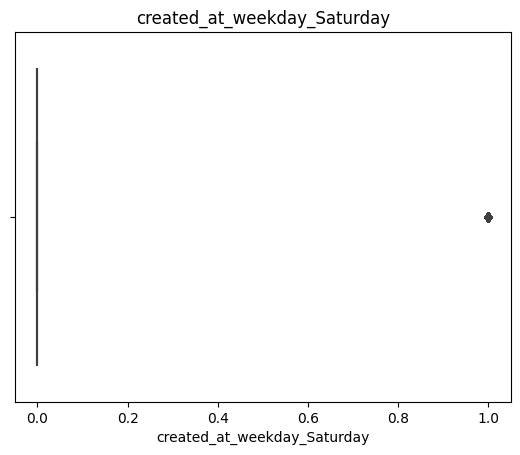

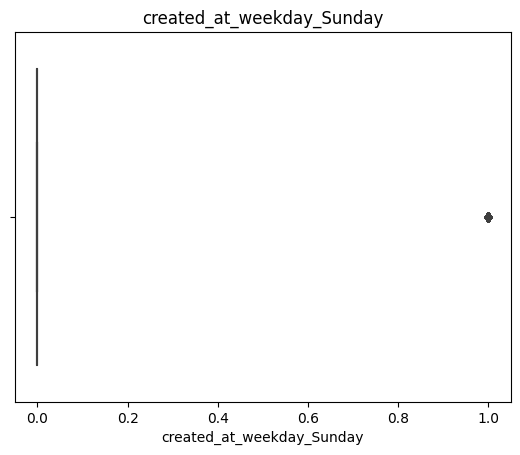

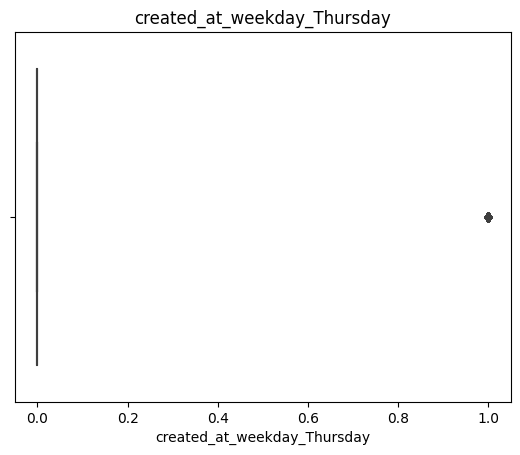

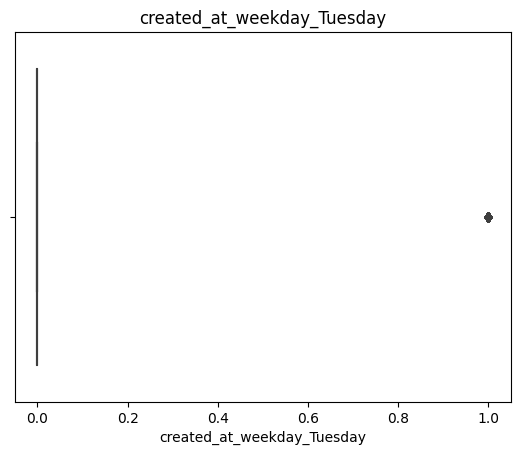

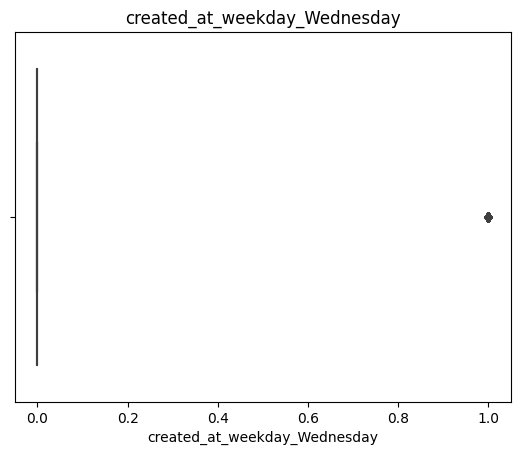

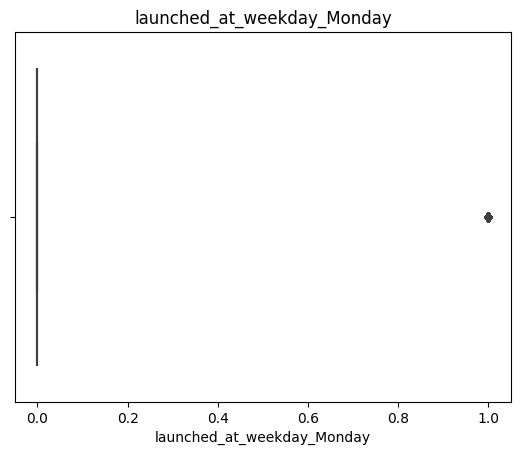

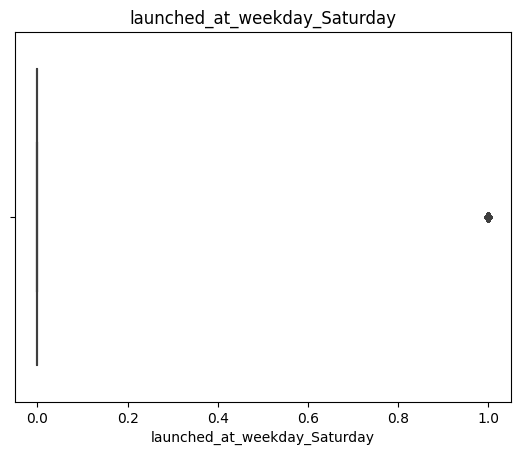

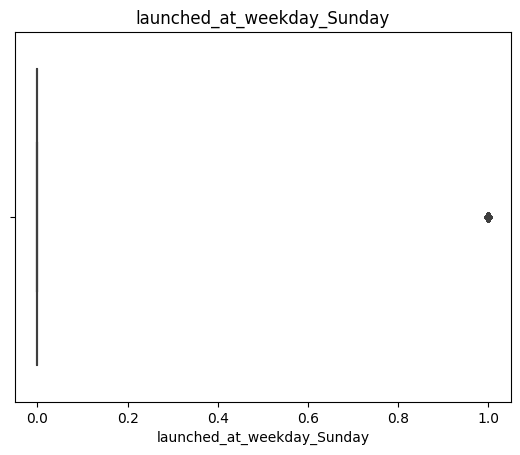

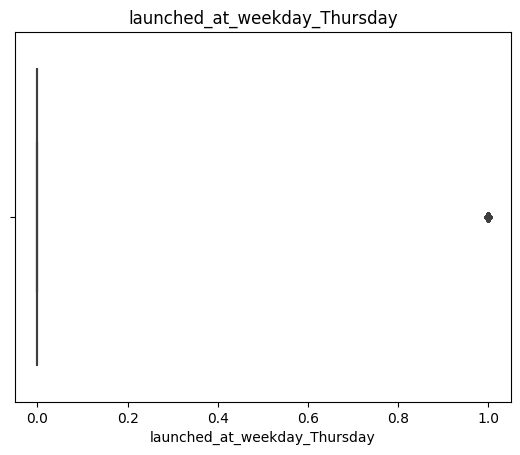

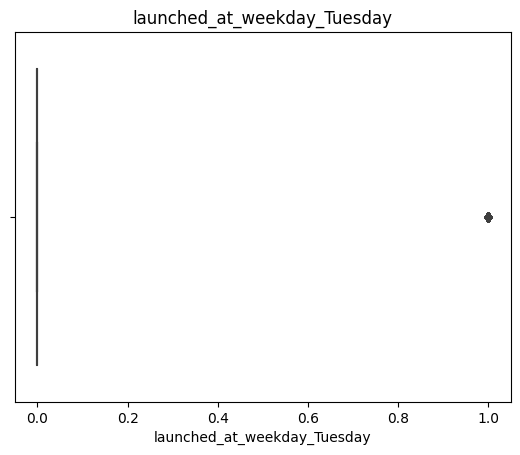

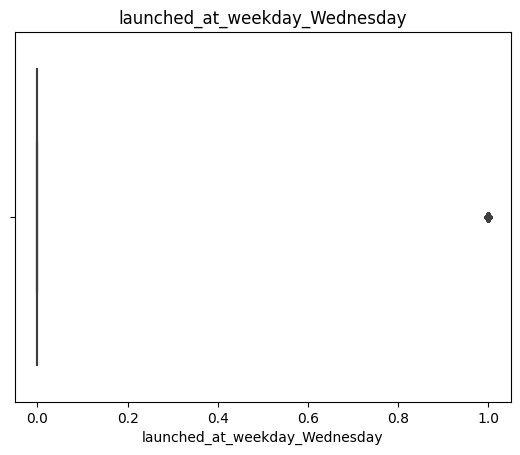

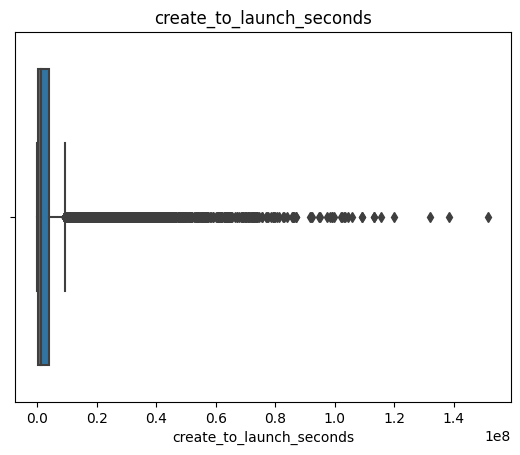

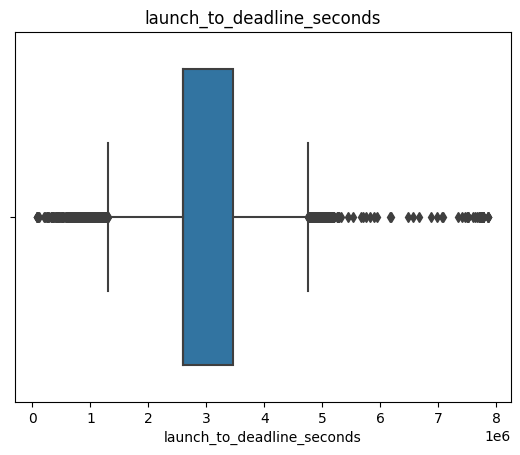

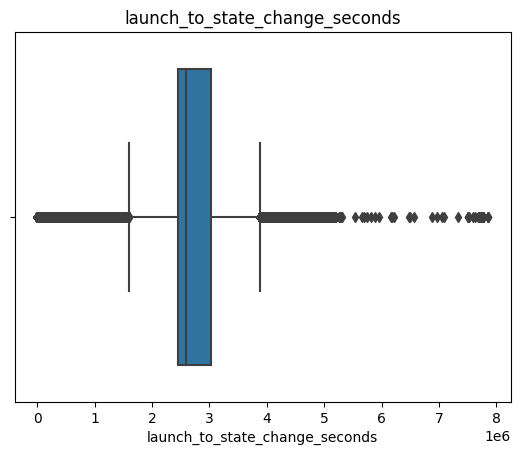

In [74]:
numeric_columns = X_train.select_dtypes(include=np.number).columns

for col in numeric_columns:
    plt.figure()
    sns.boxplot(x=X_train[col])
    plt.title(col)


/var/folders/lx/xmx3rkvn0f71ry2n4cf0b9880000gn/T/ipykernel_64384/3312671866.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


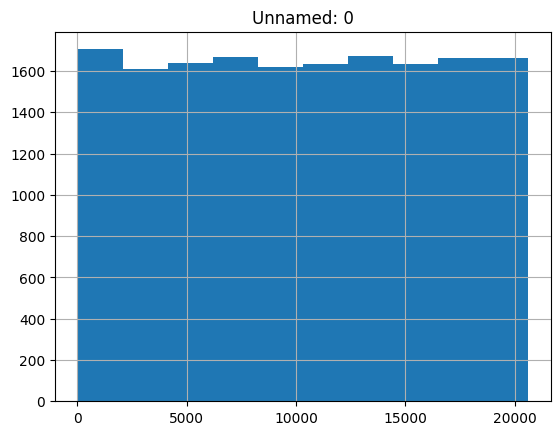

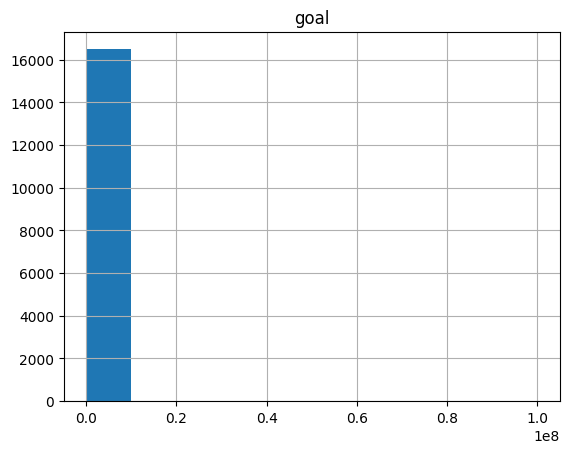

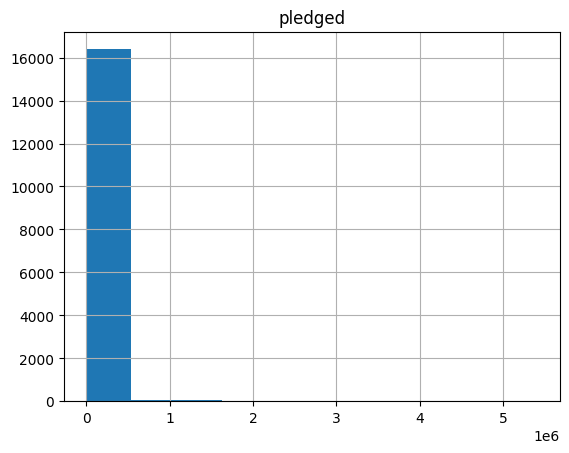

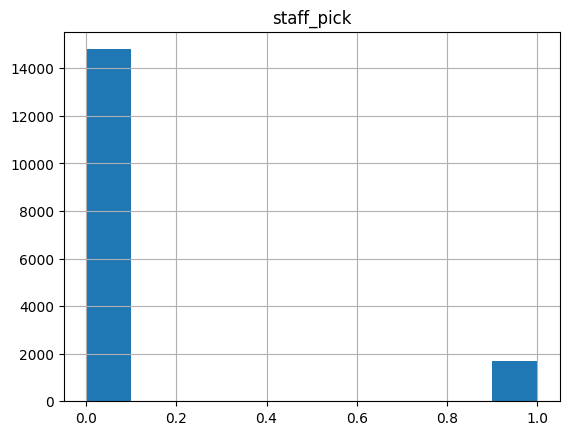

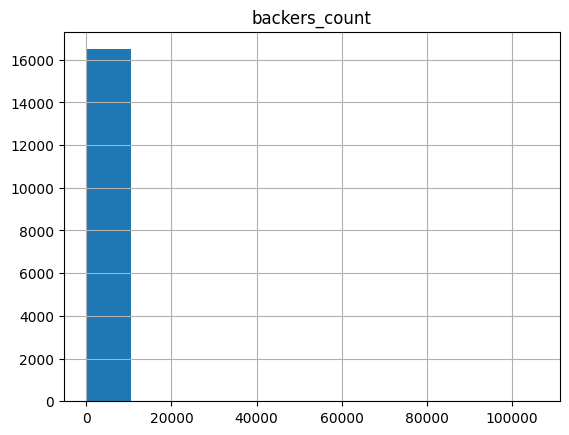

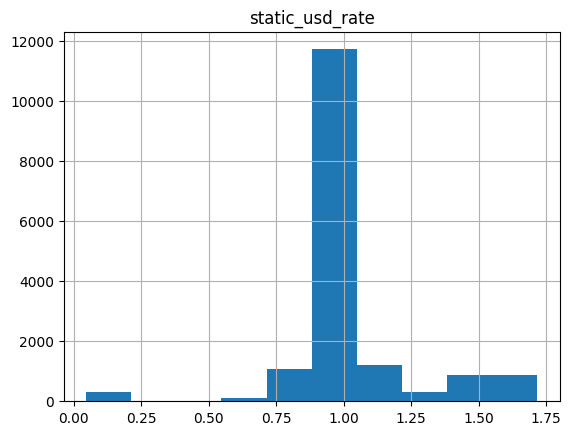

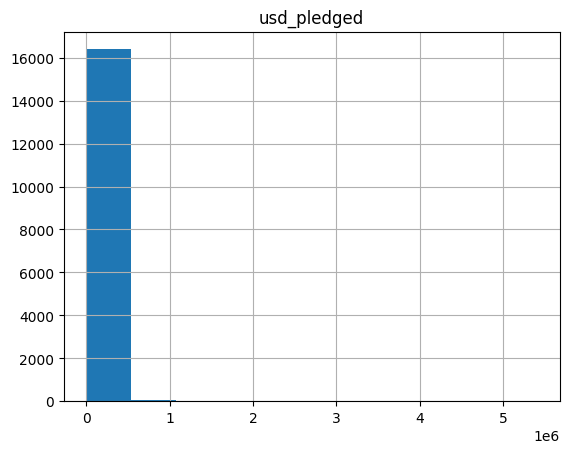

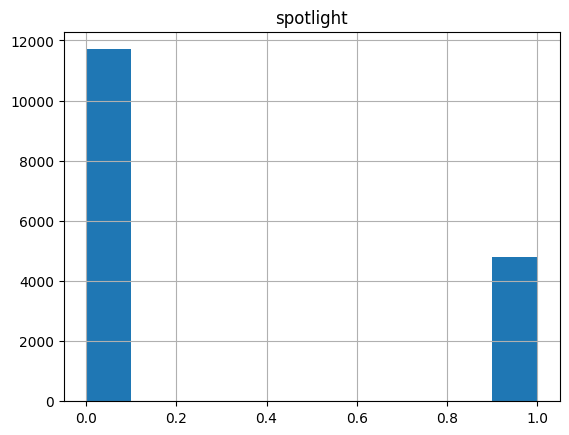

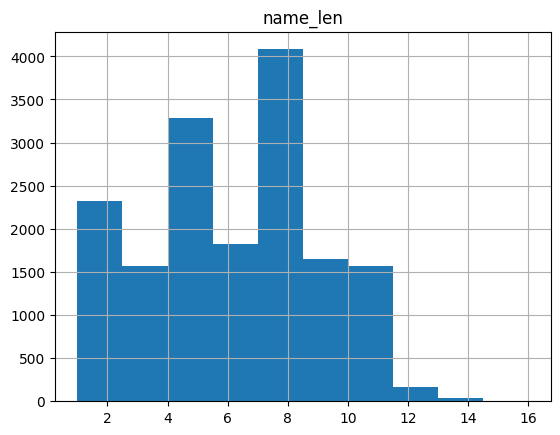

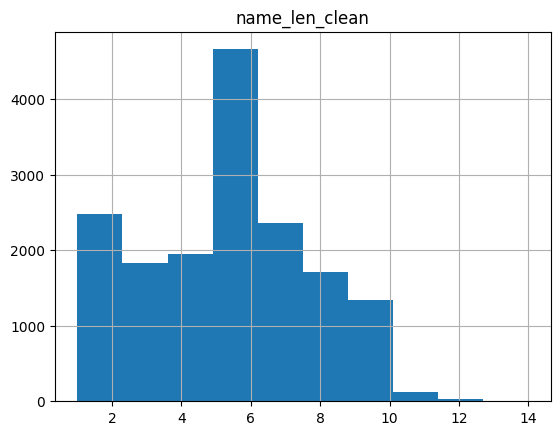

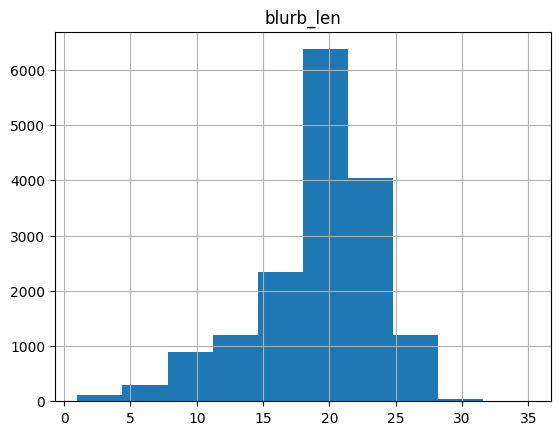

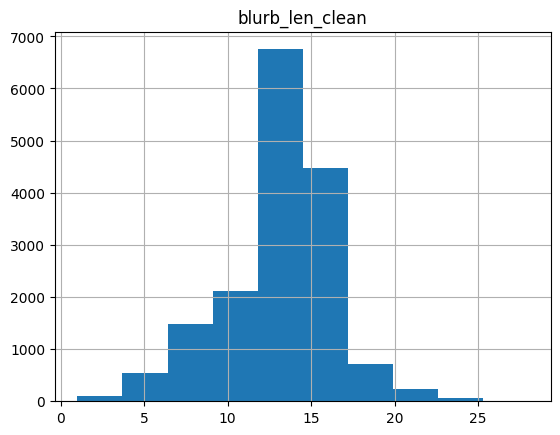

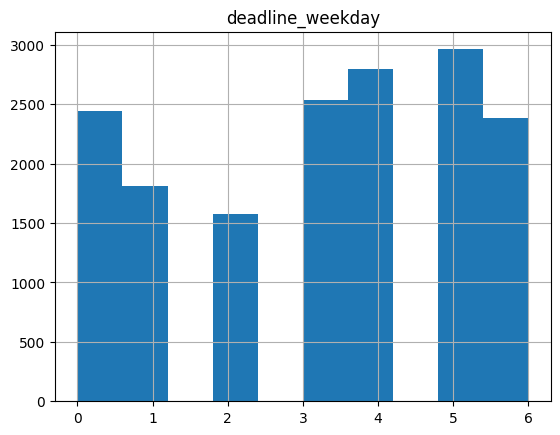

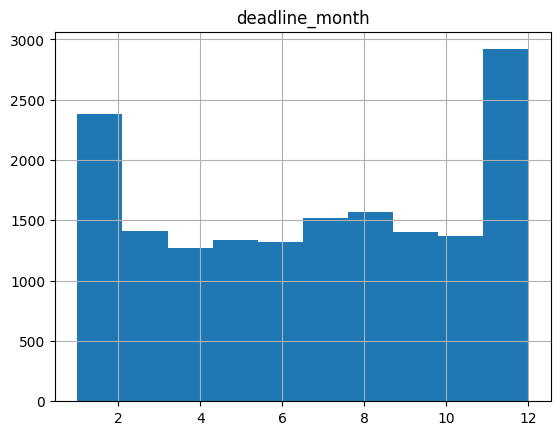

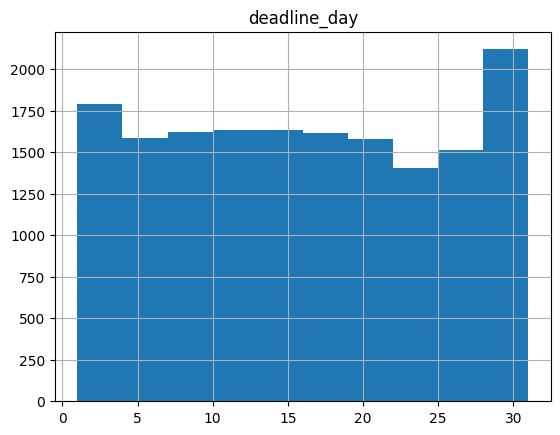

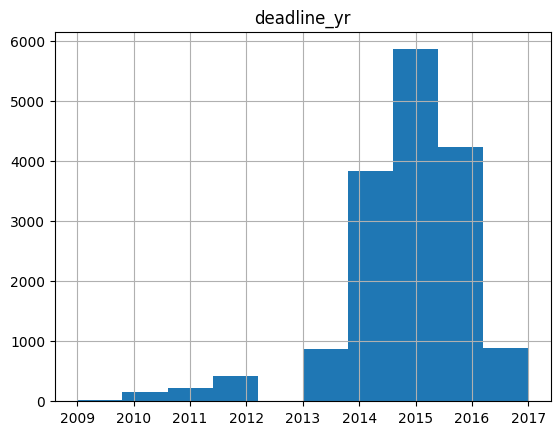

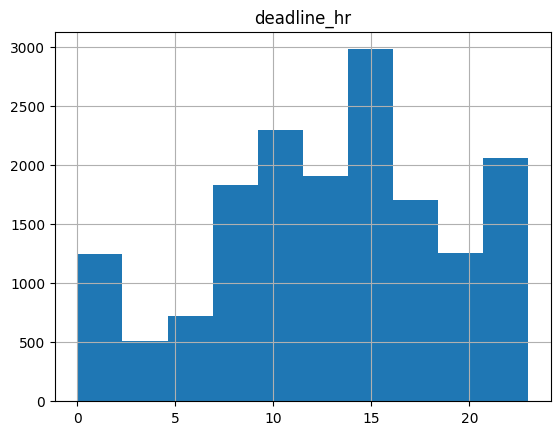

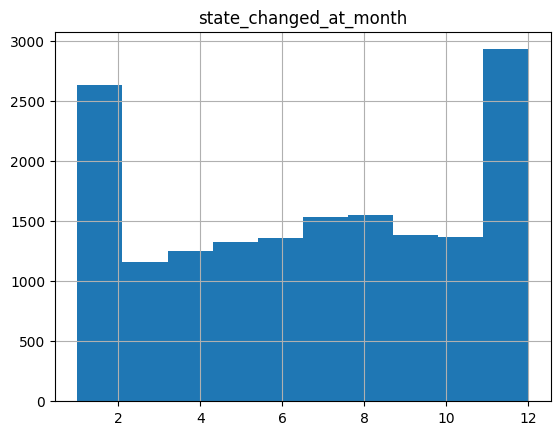

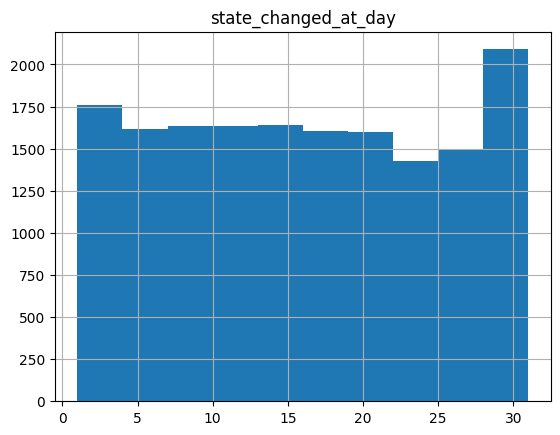

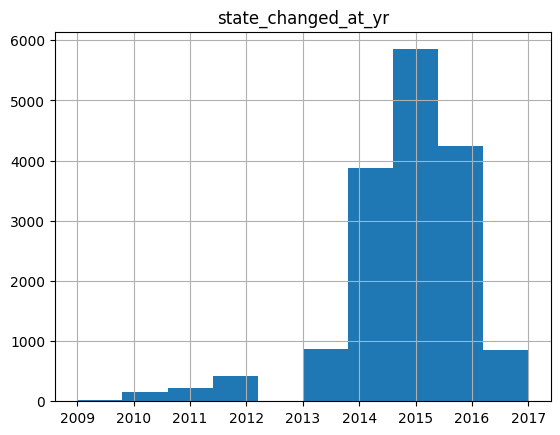

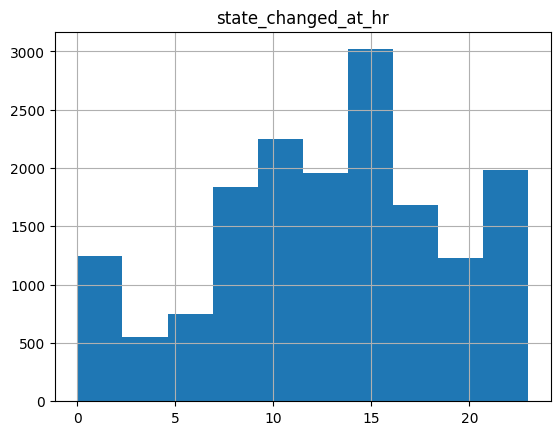

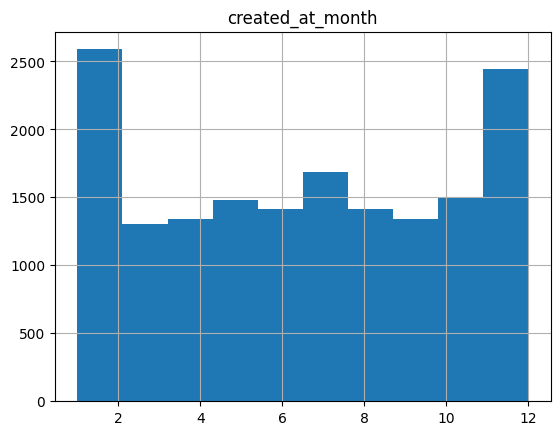

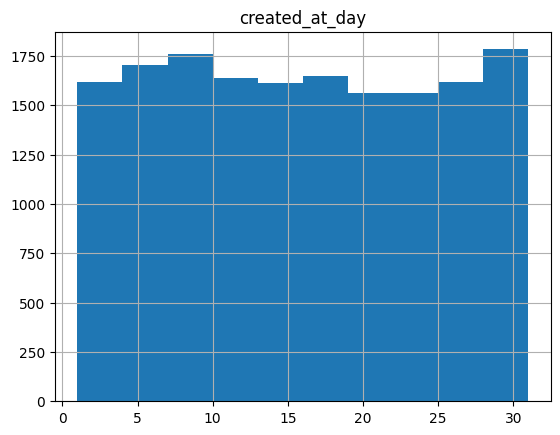

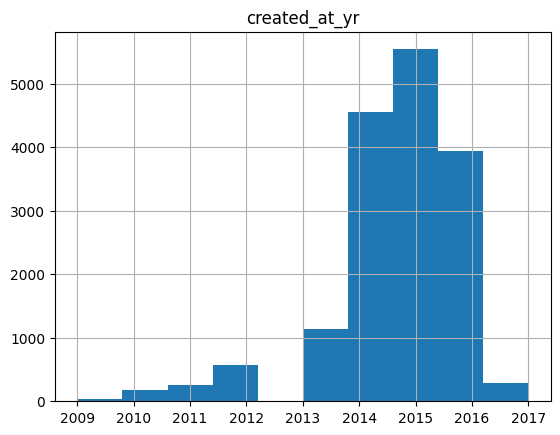

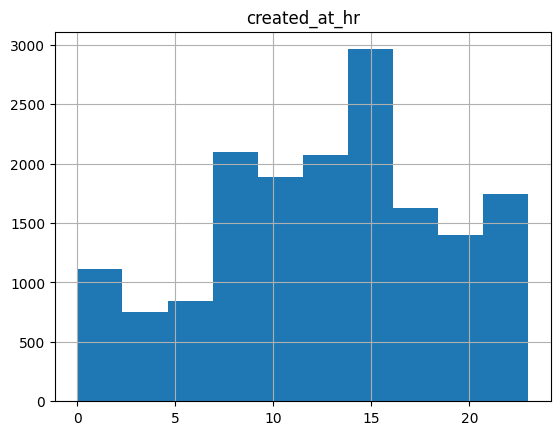

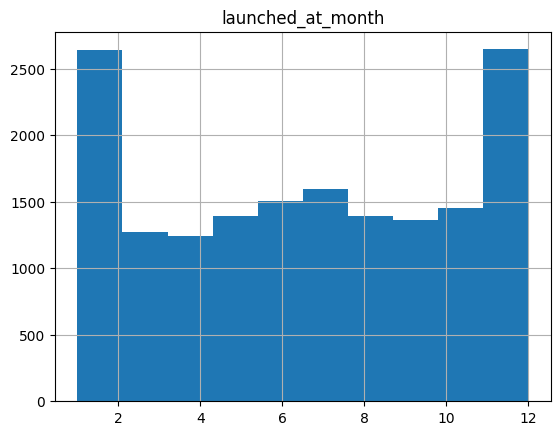

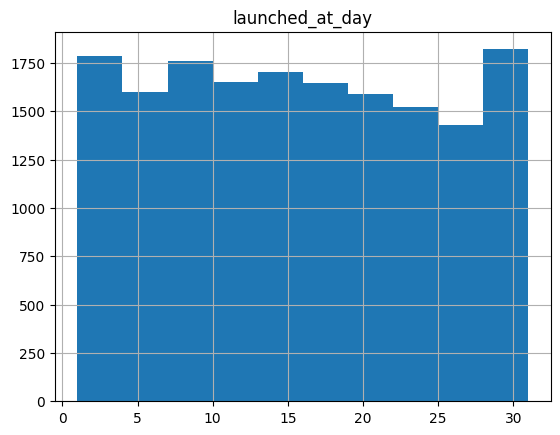

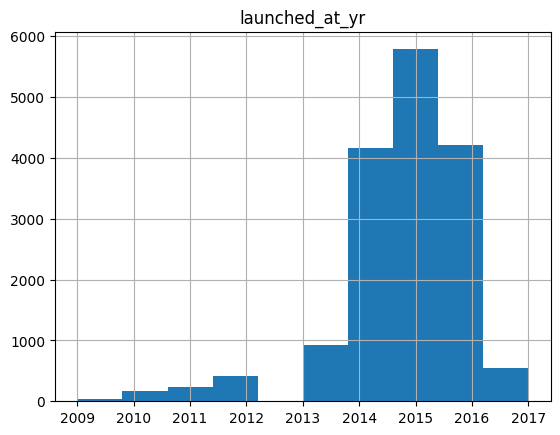

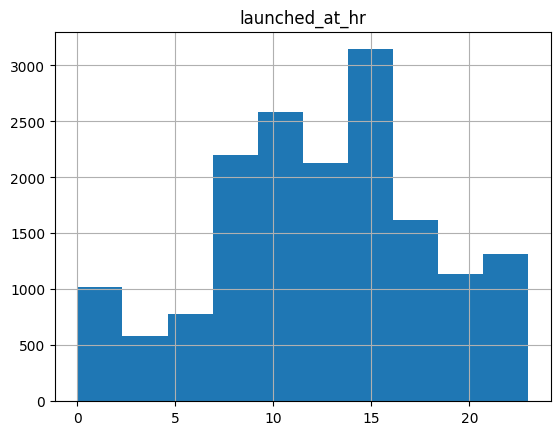

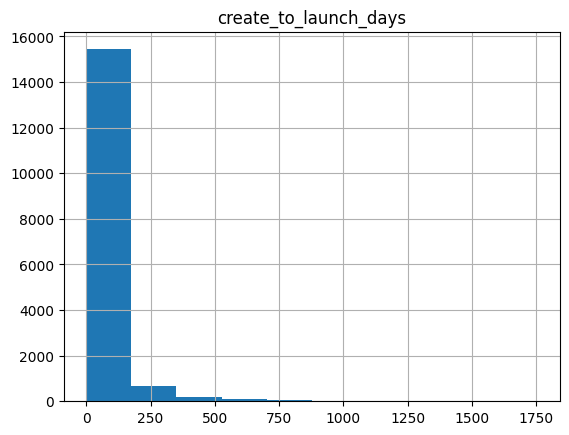

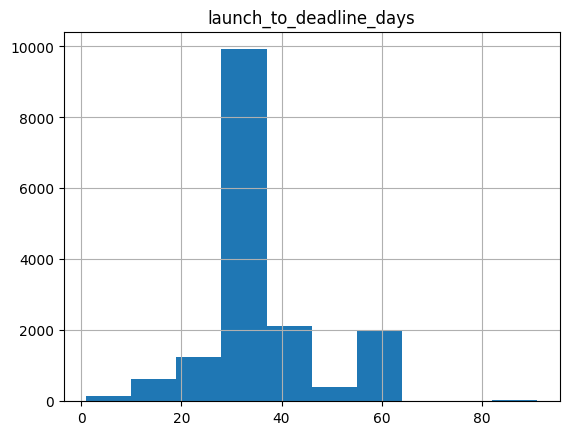

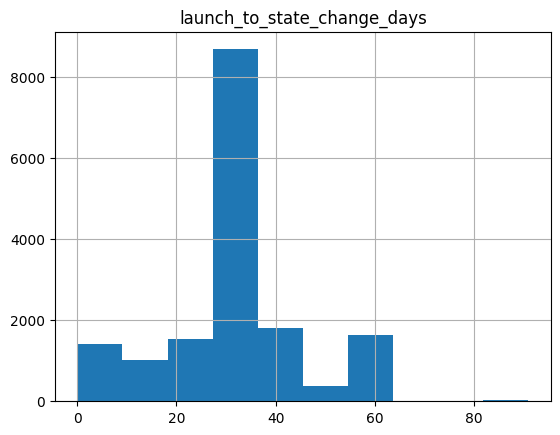

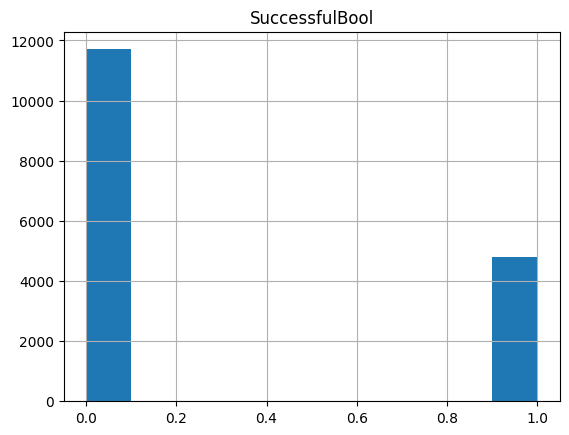

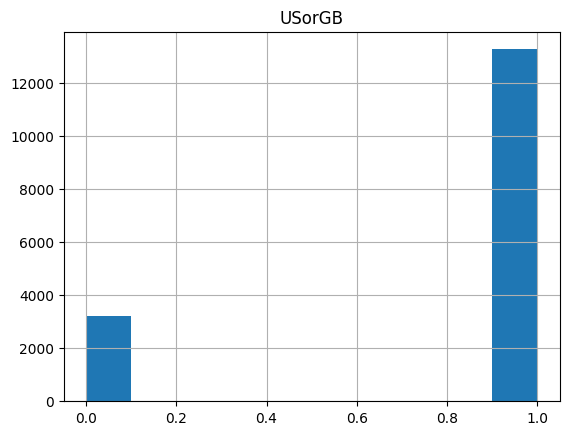

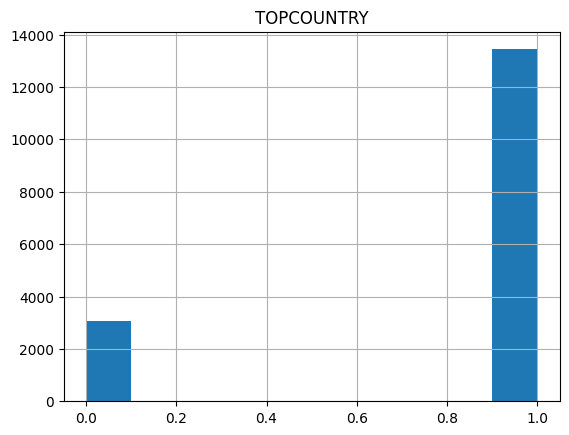

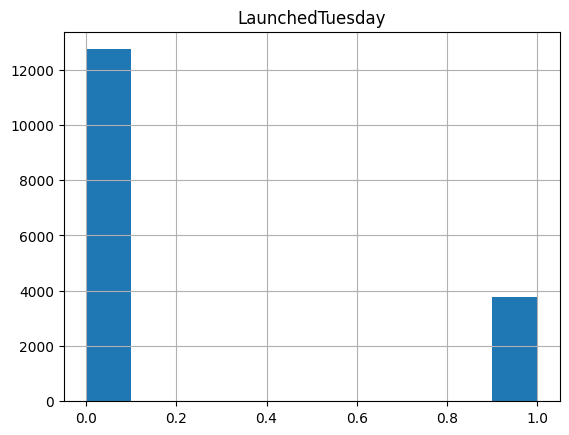

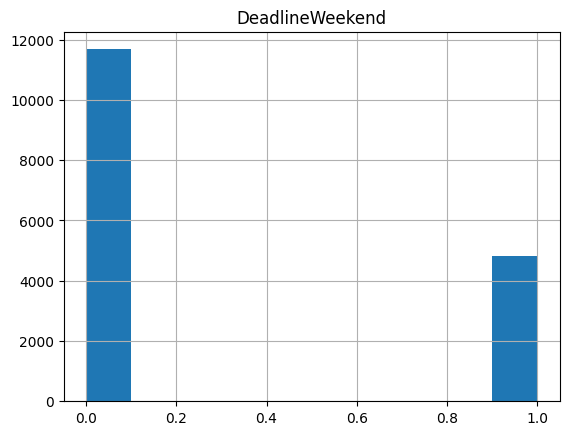

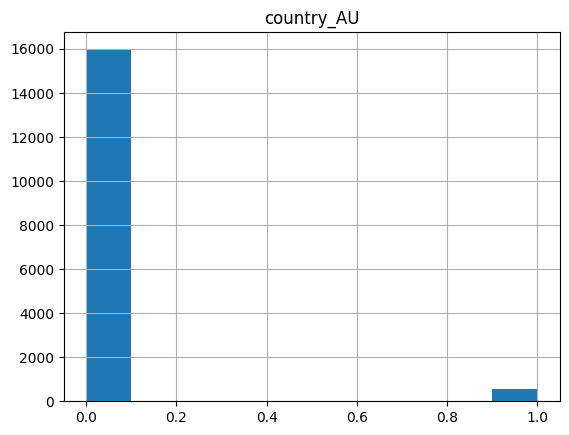

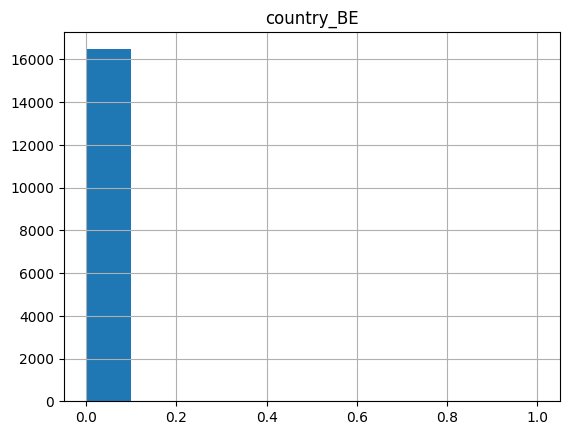

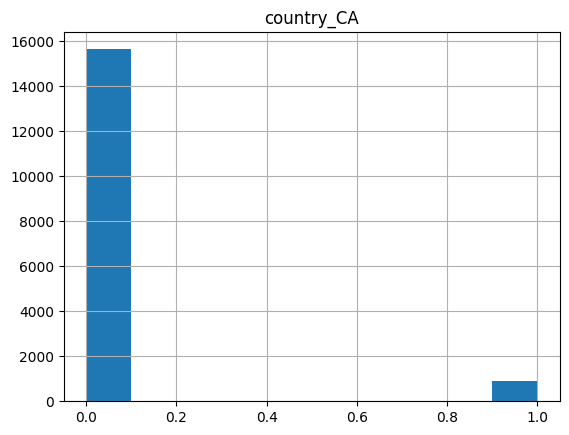

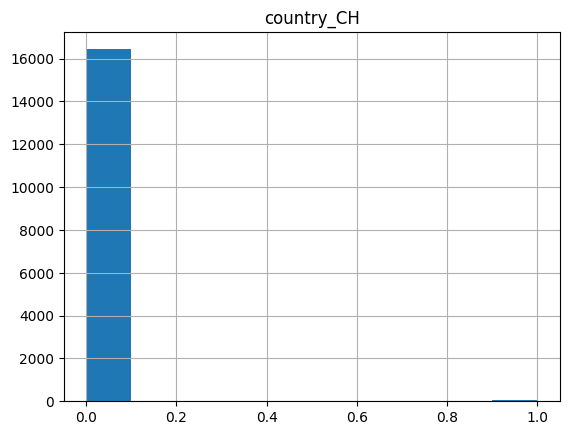

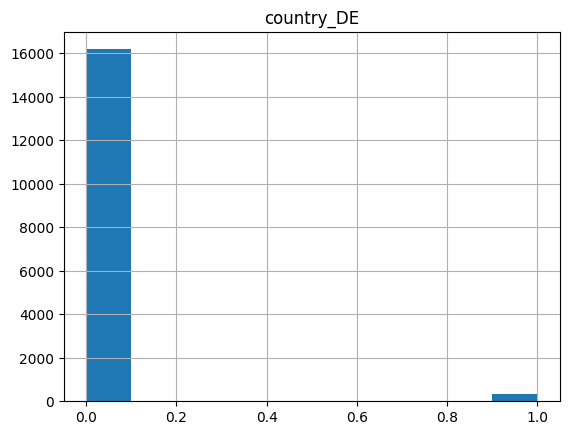

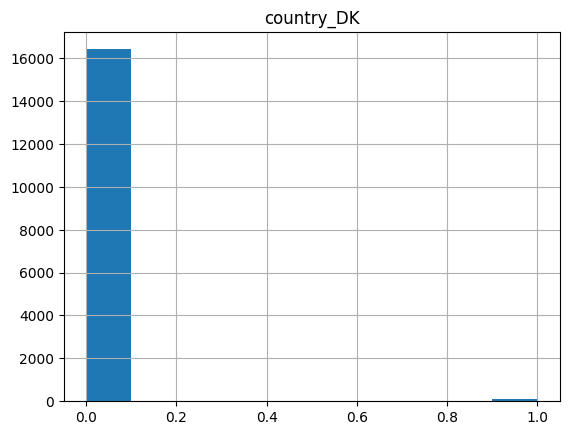

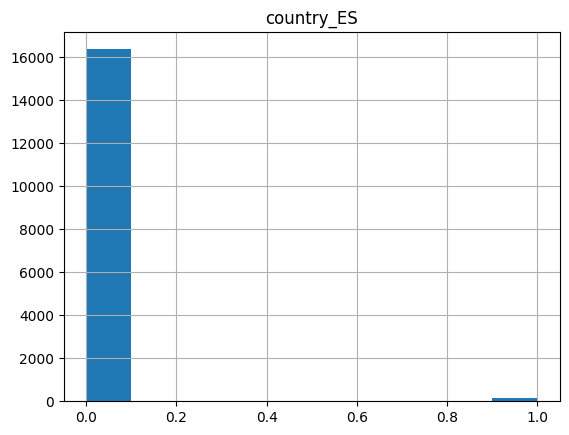

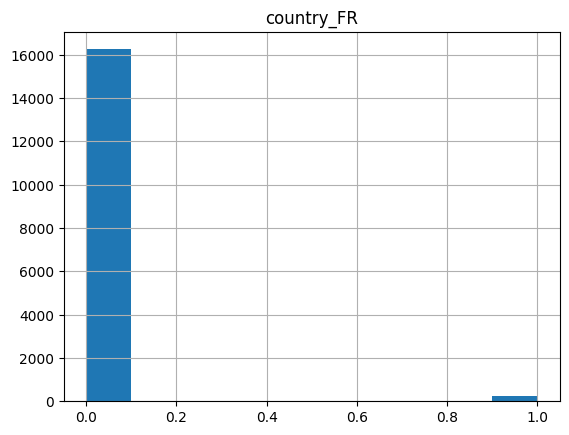

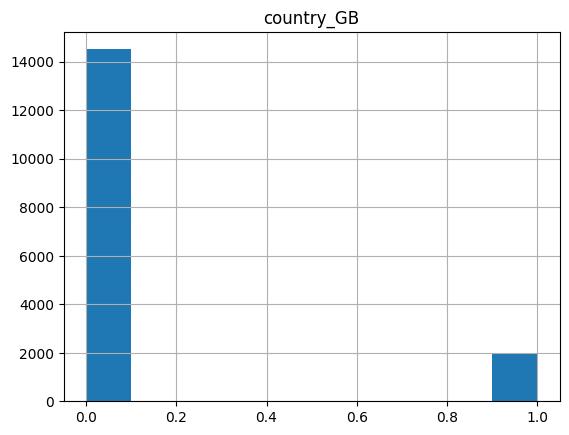

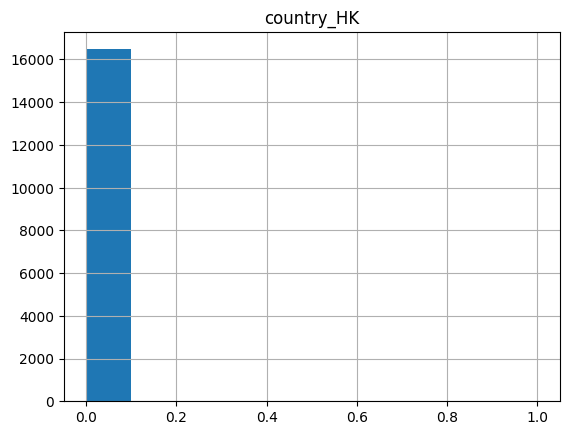

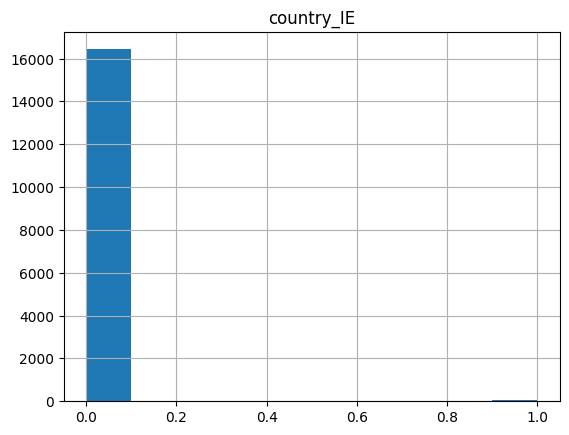

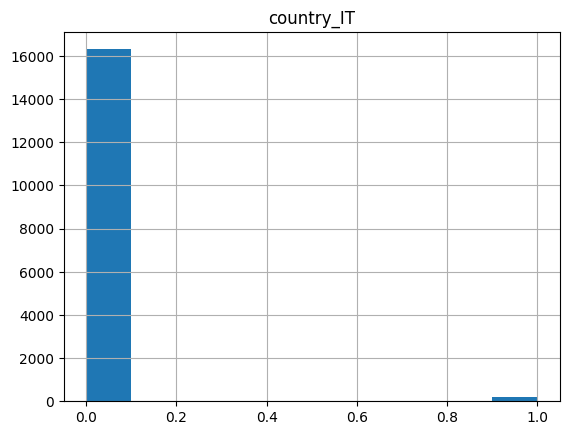

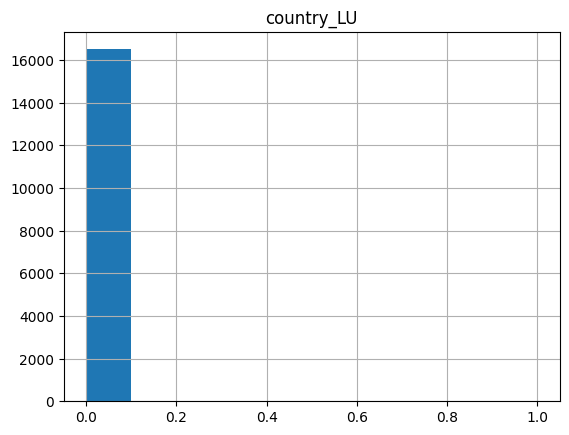

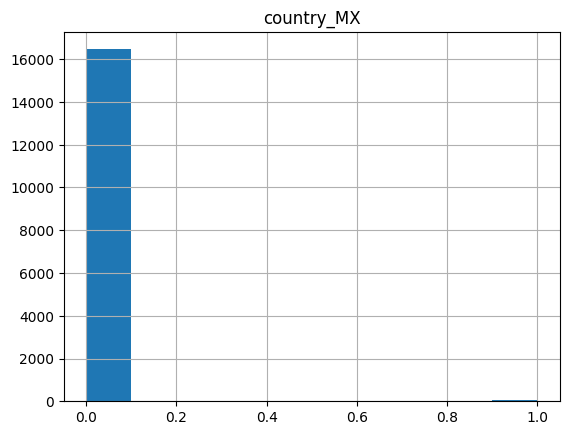

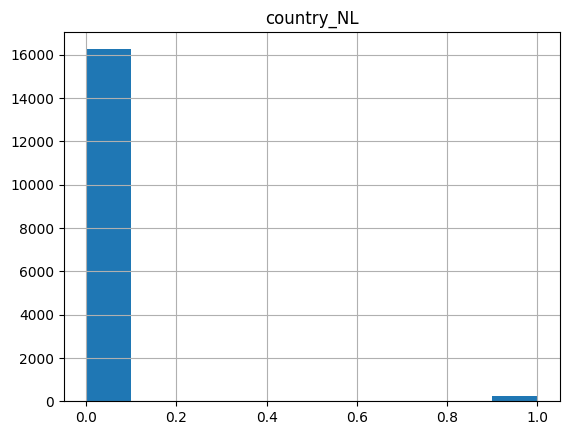

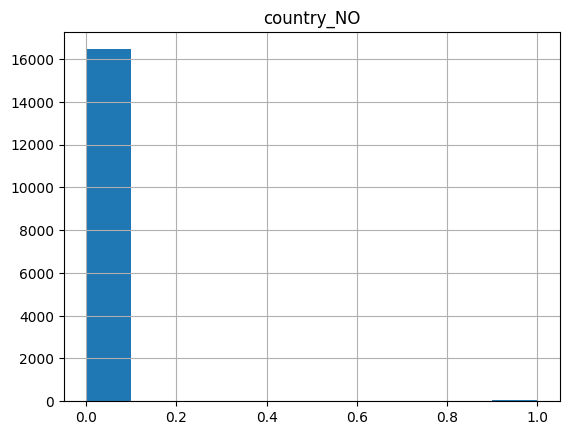

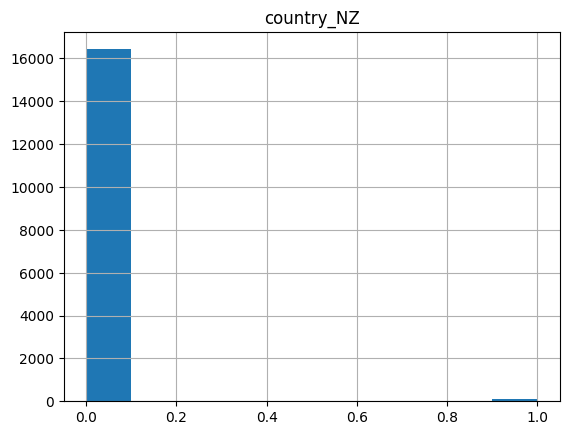

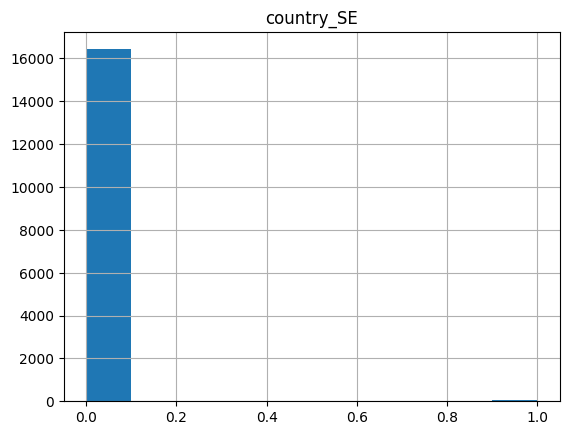

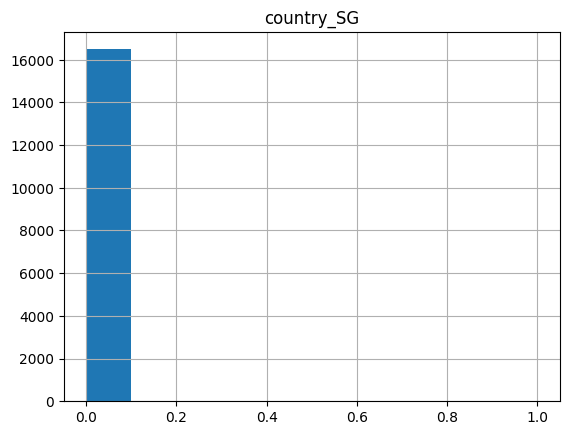

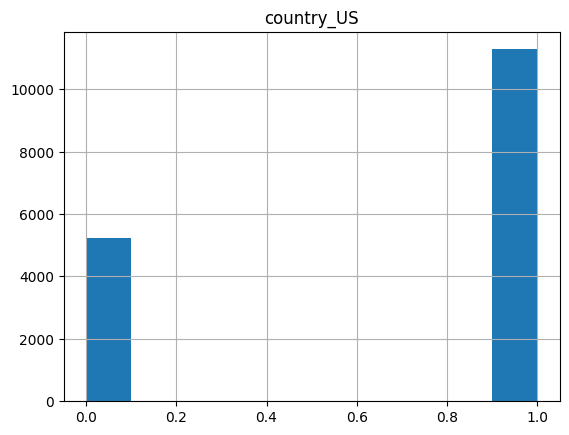

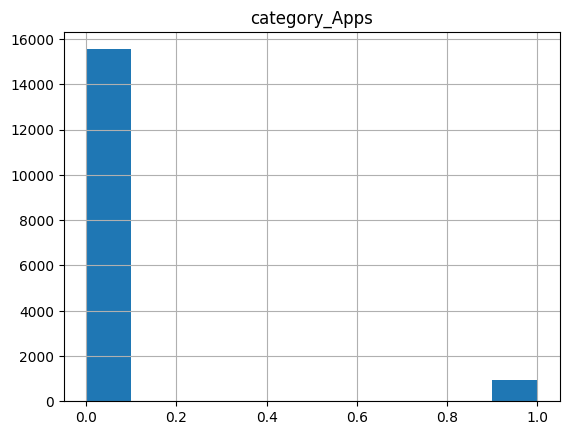

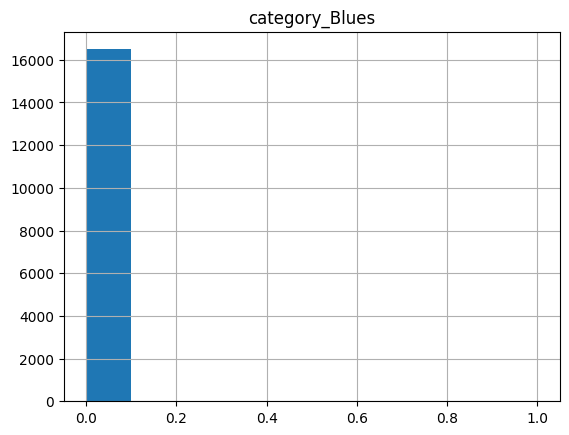

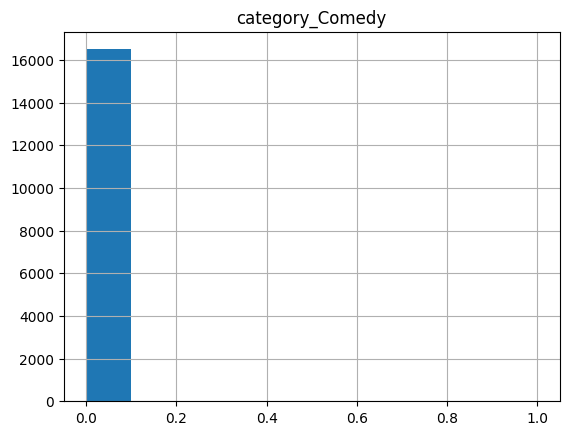

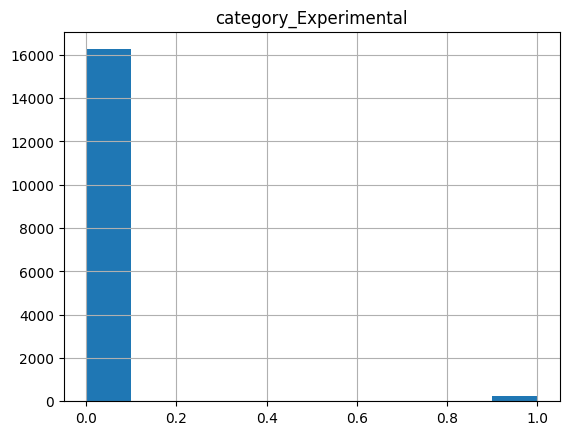

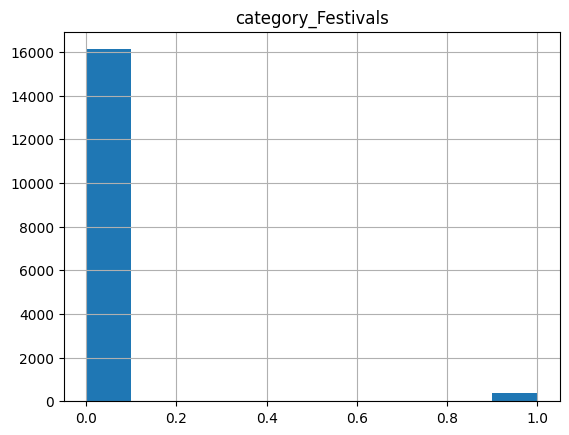

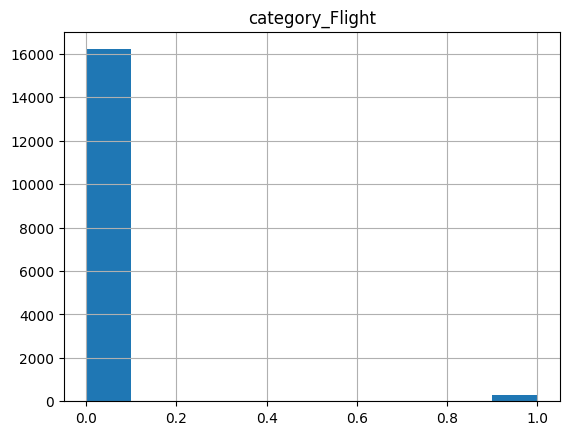

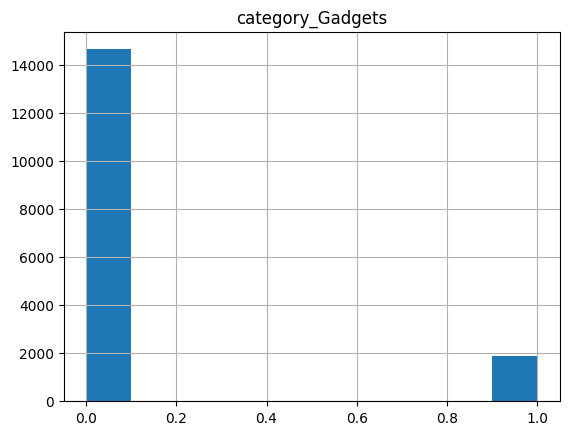

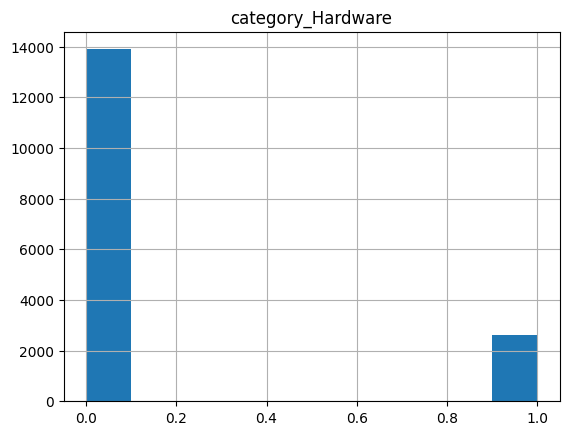

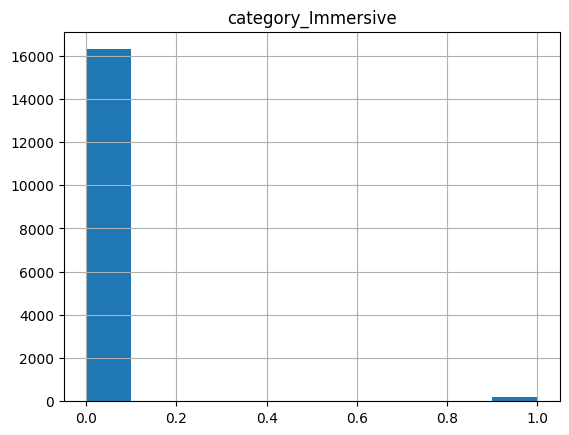

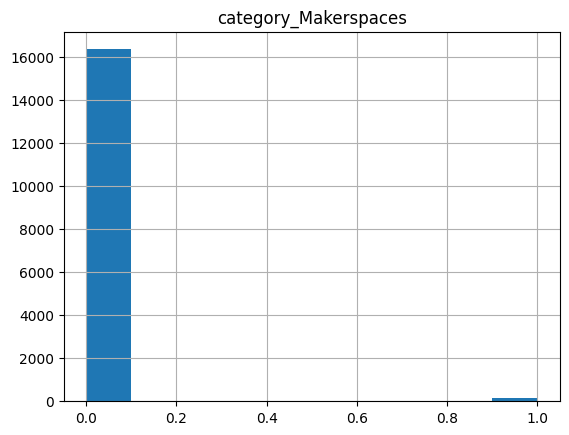

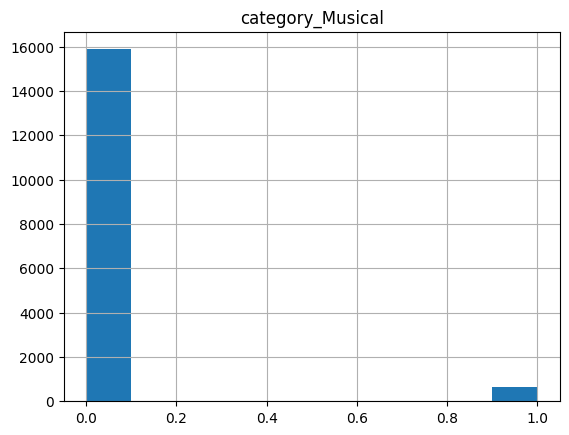

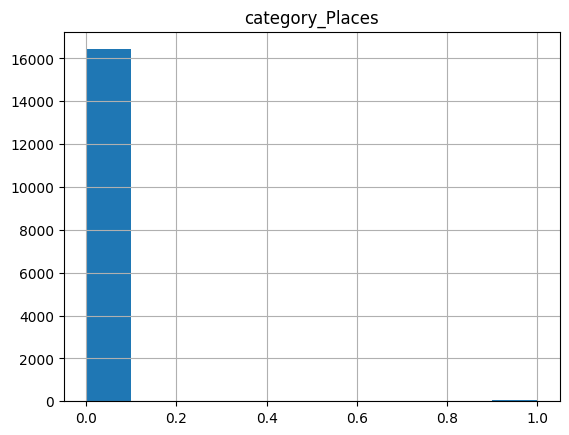

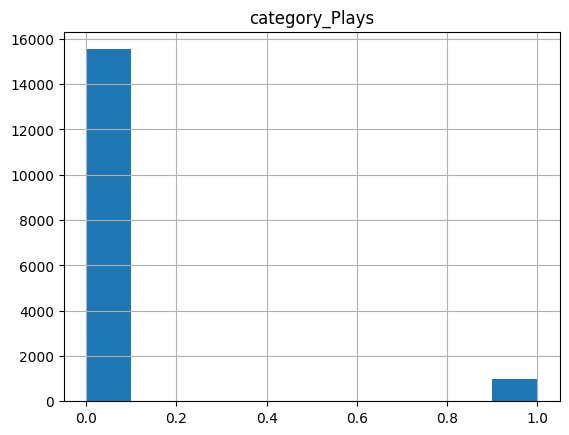

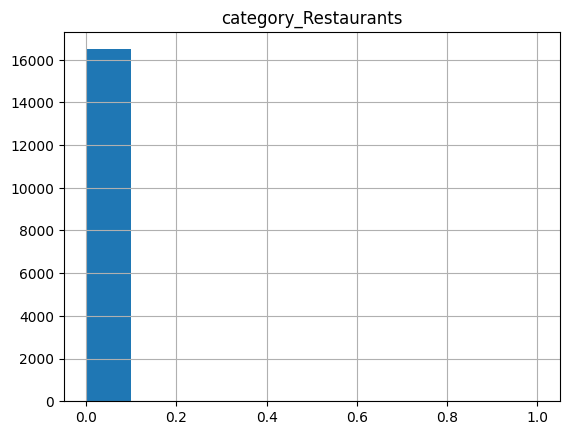

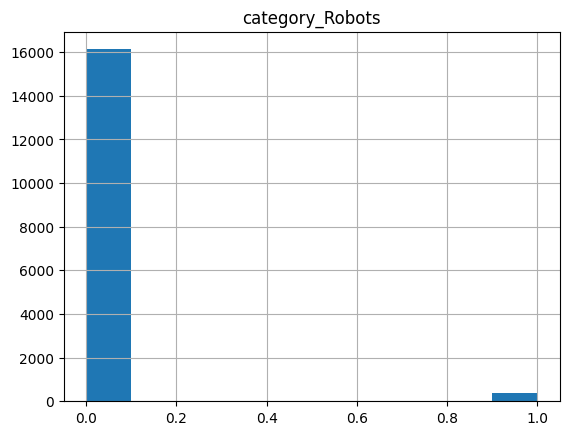

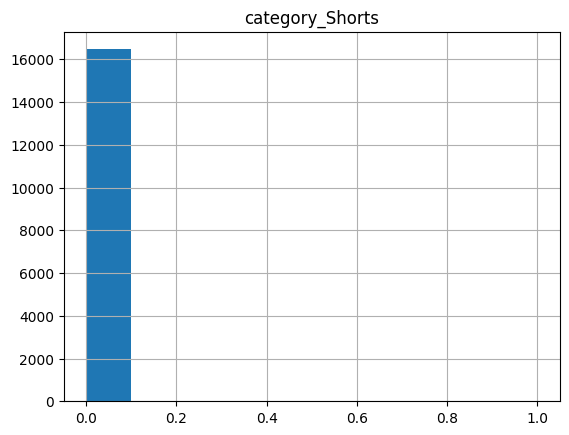

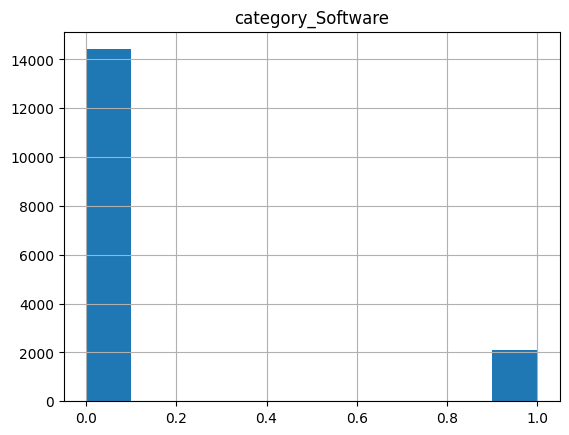

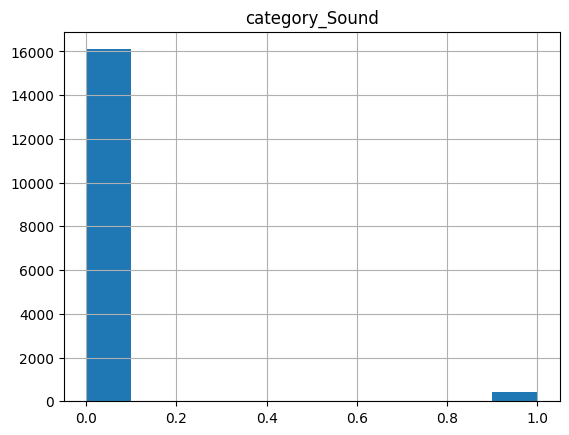

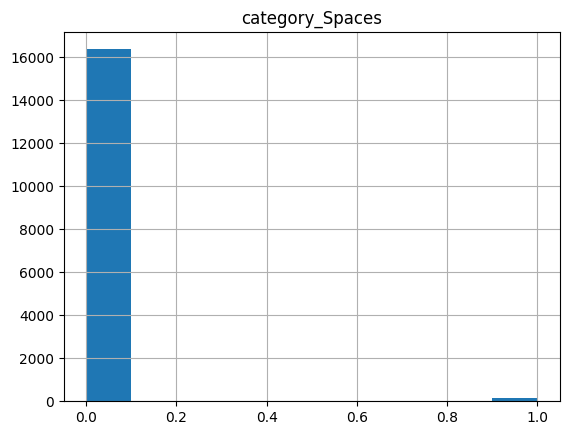

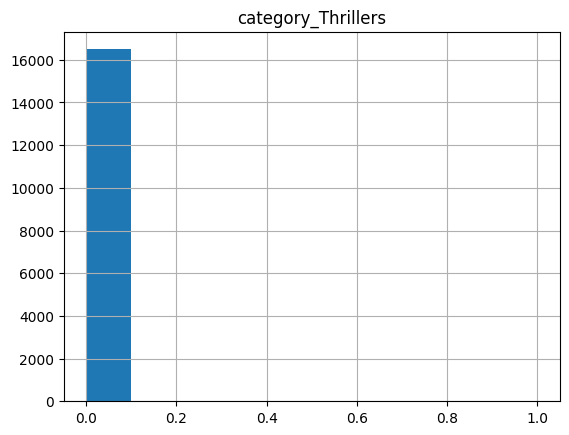

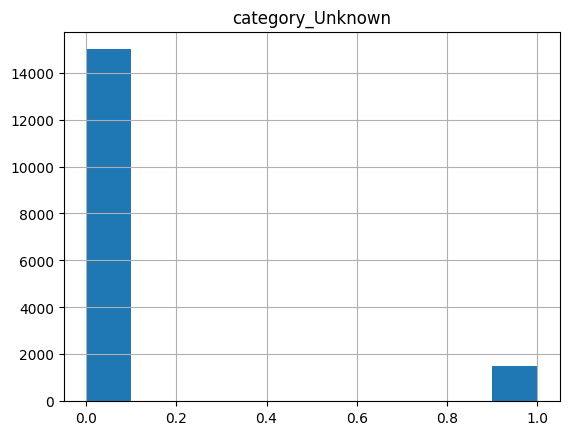

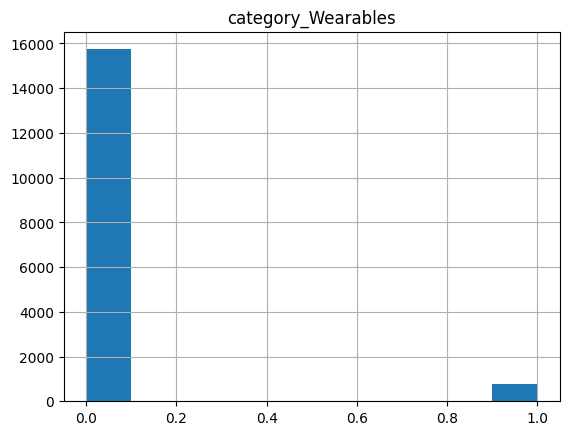

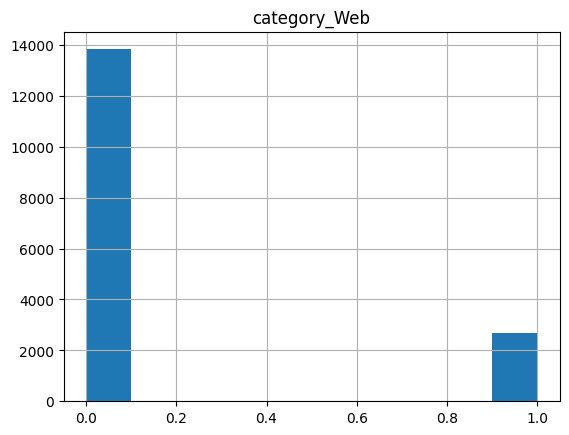

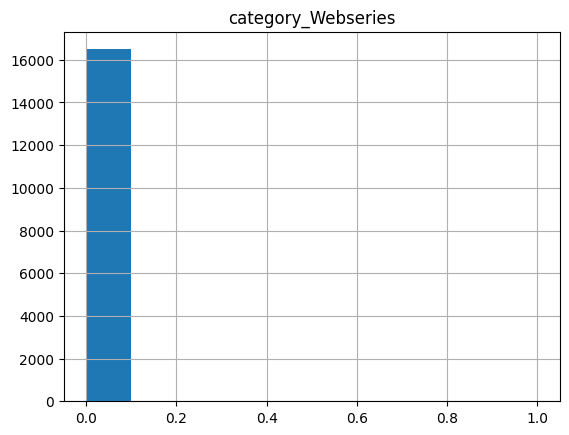

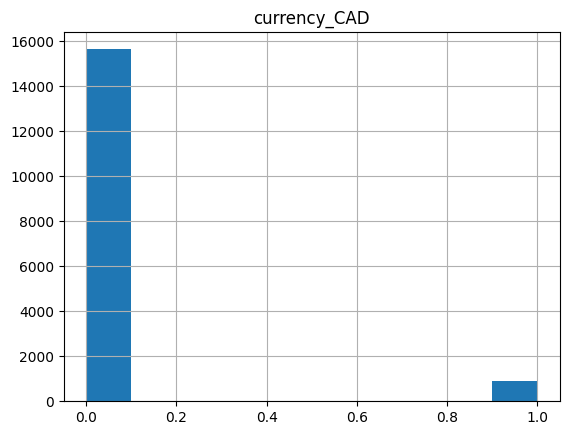

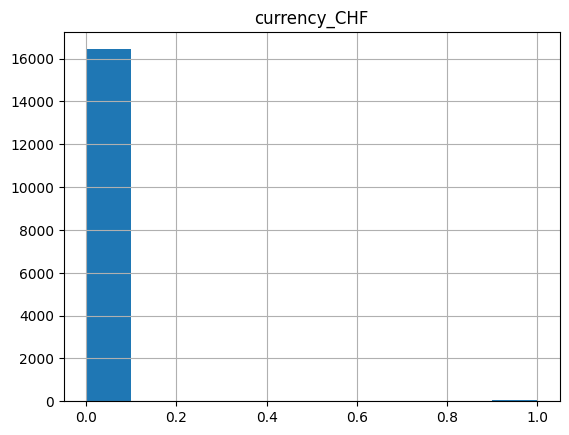

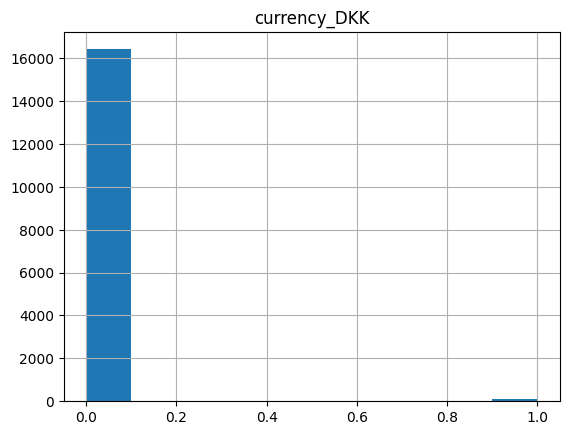

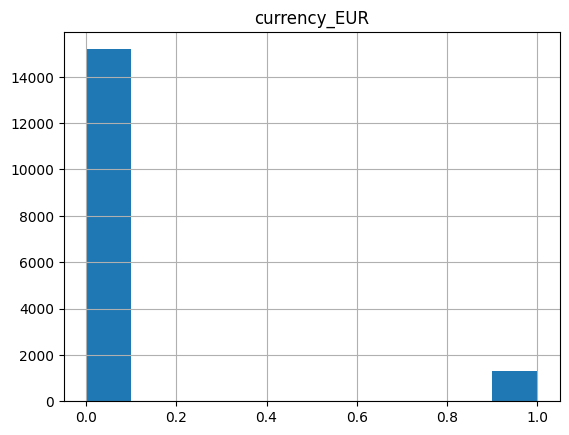

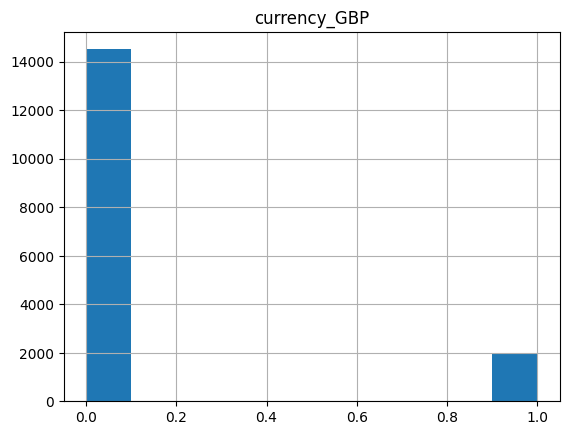

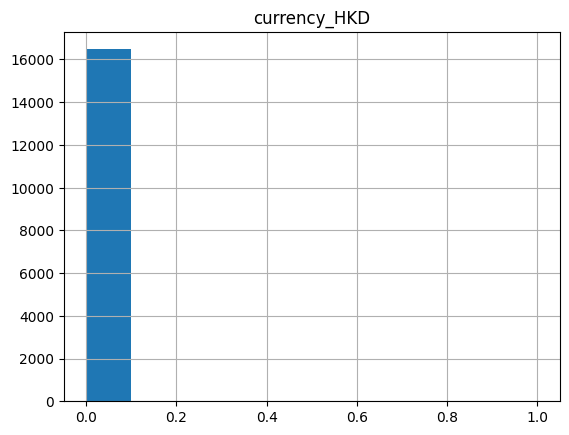

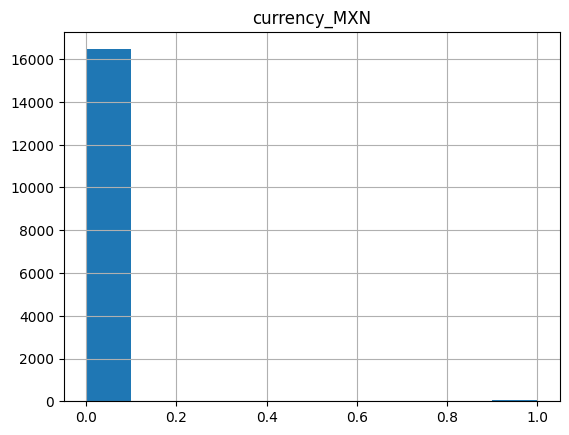

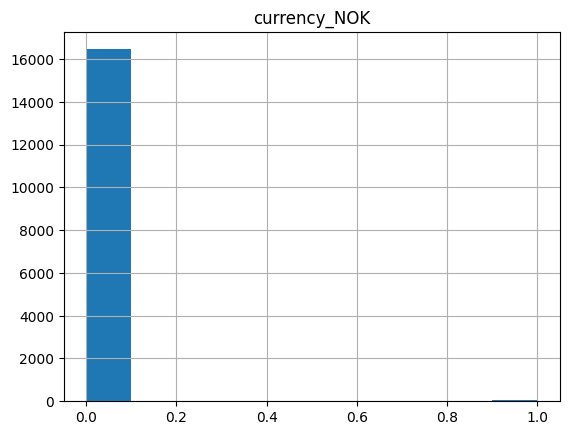

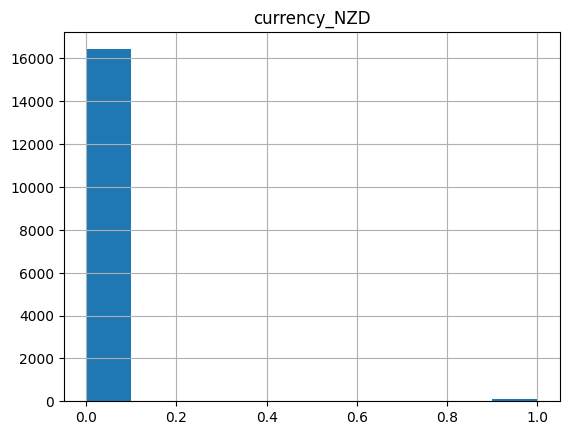

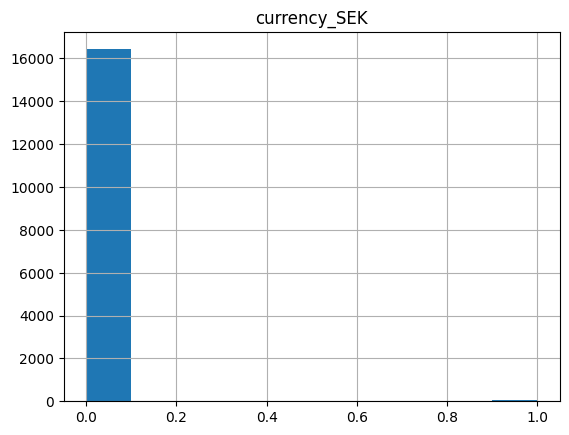

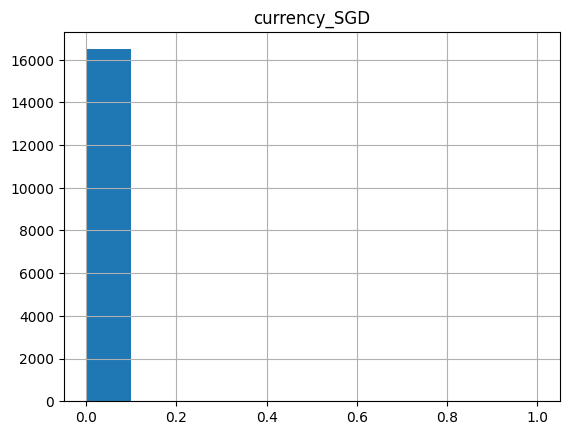

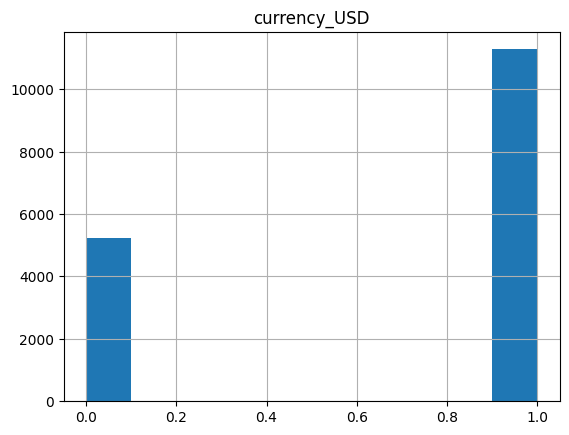

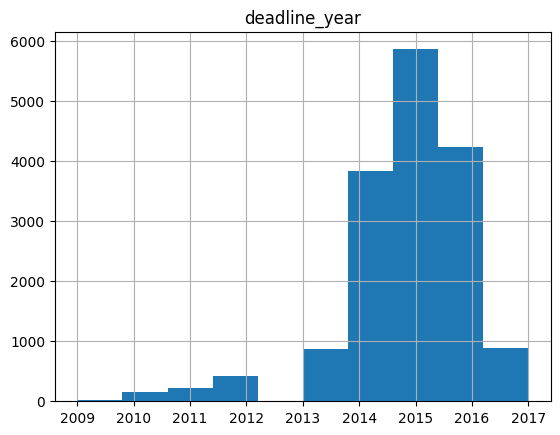

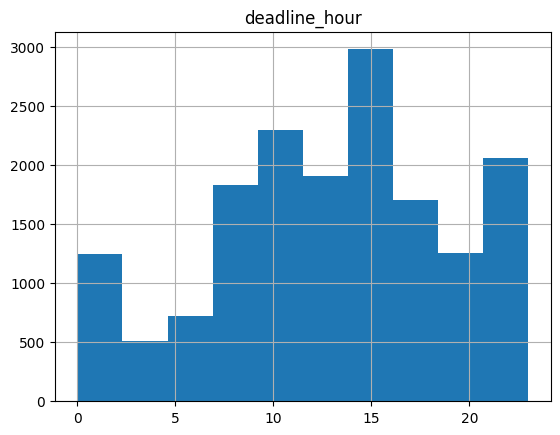

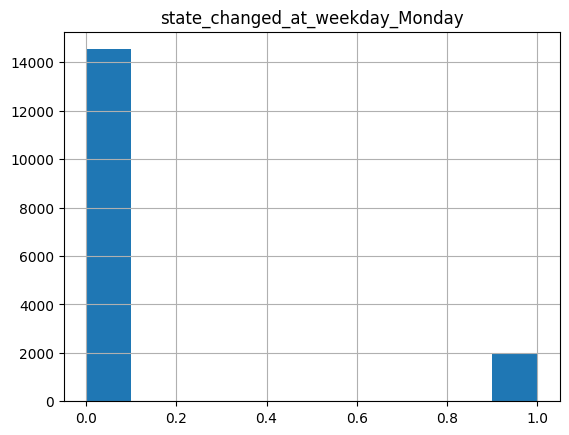

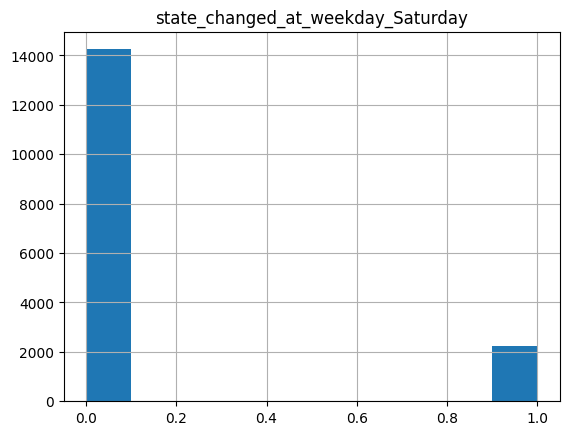

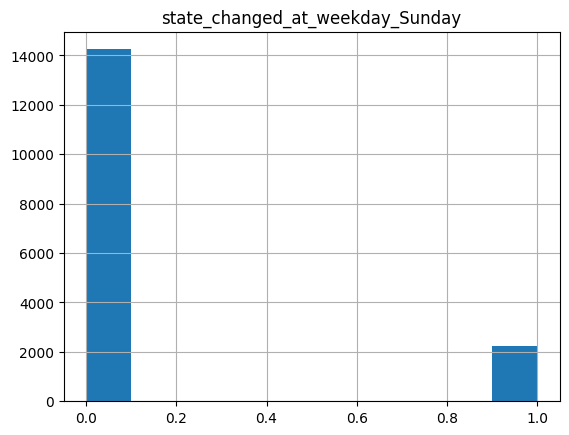

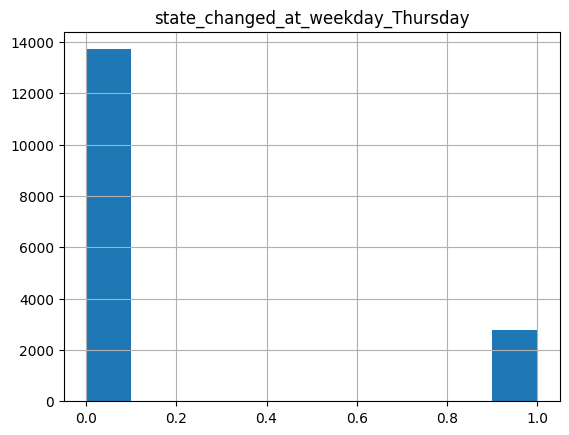

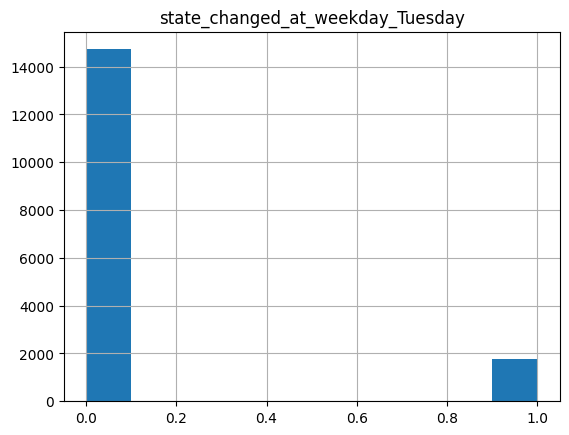

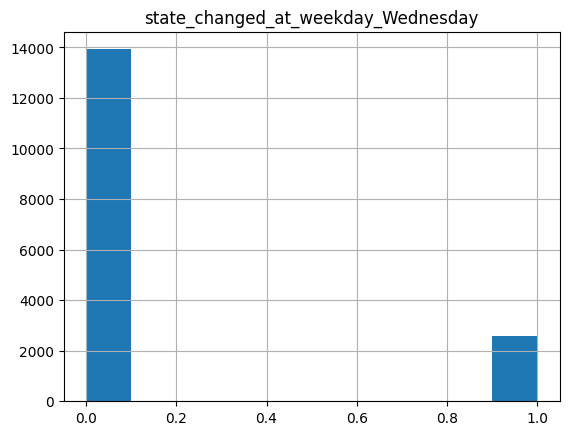

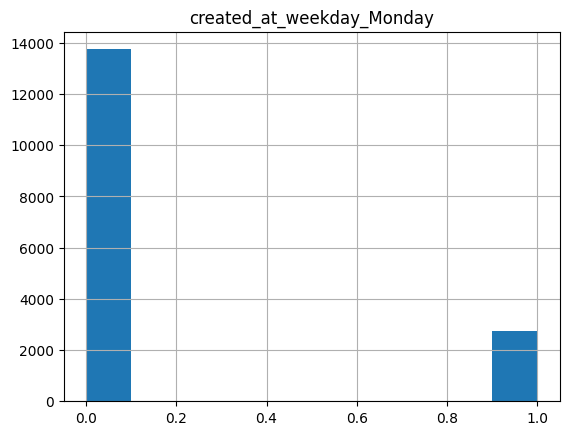

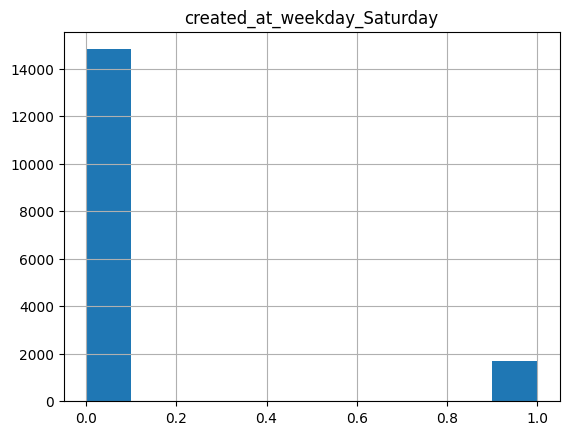

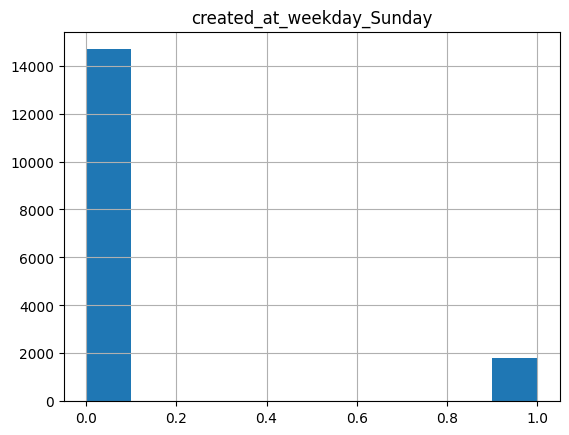

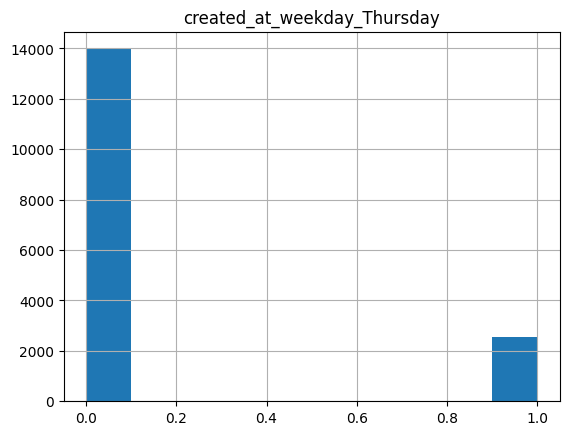

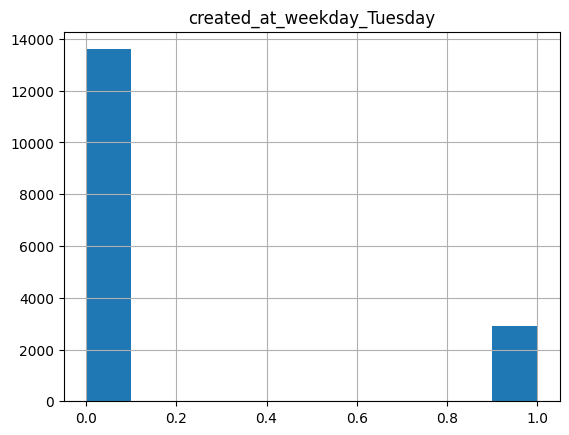

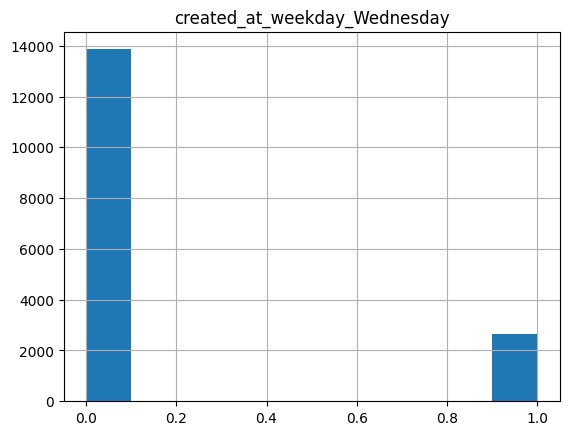

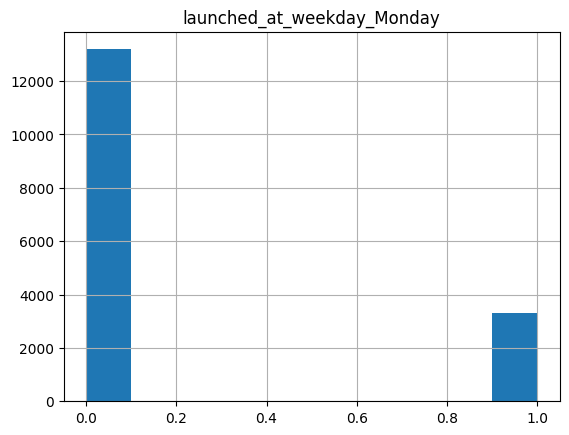

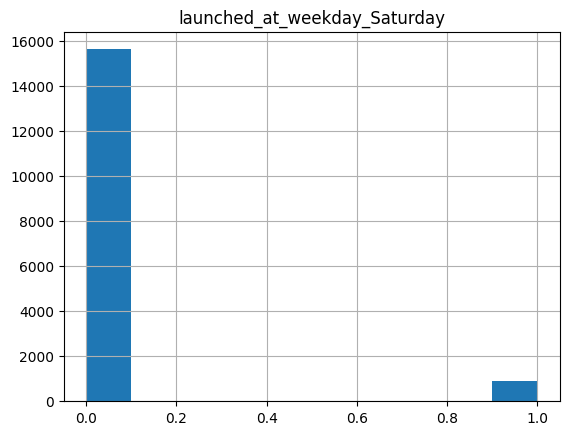

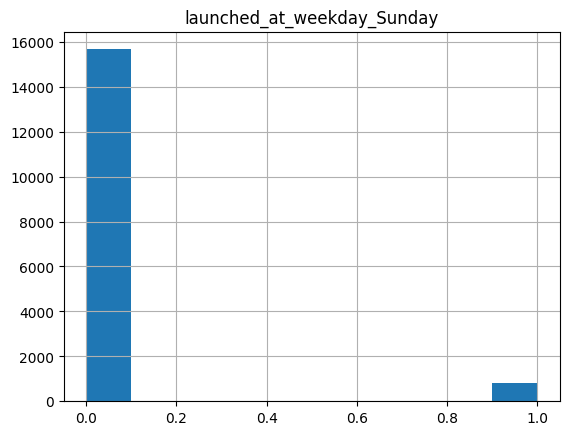

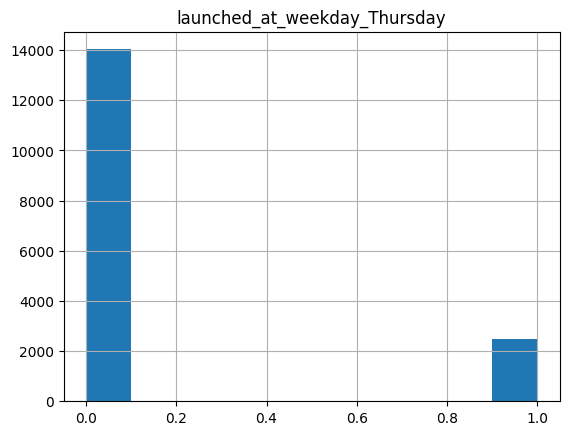

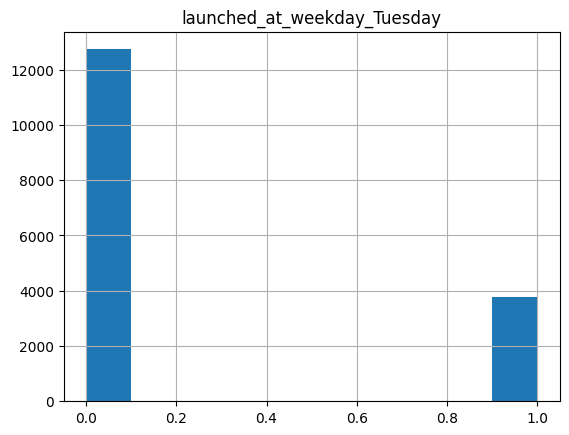

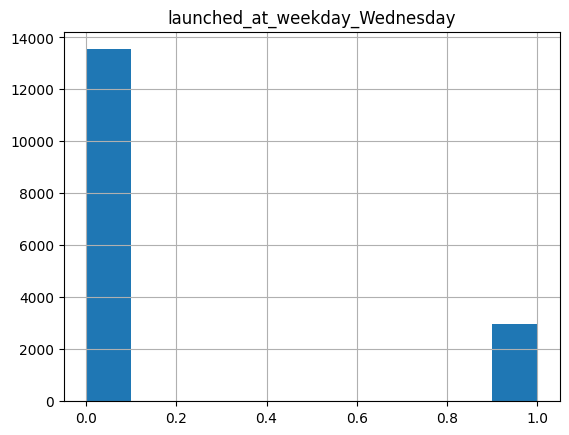

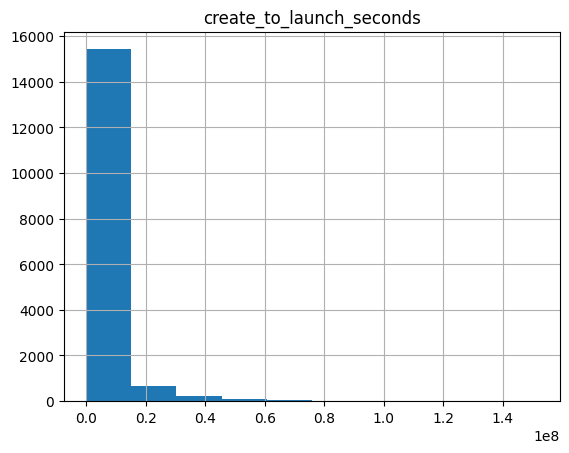

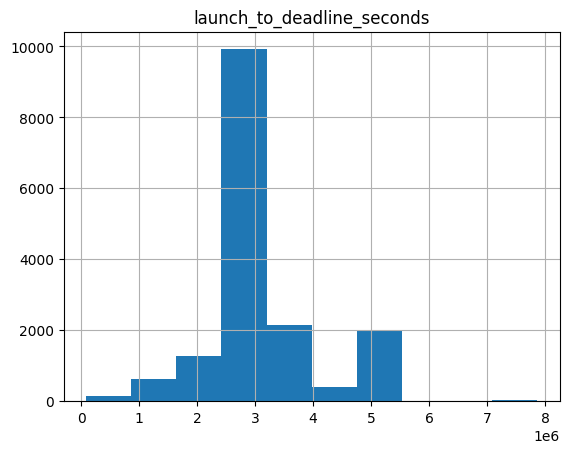

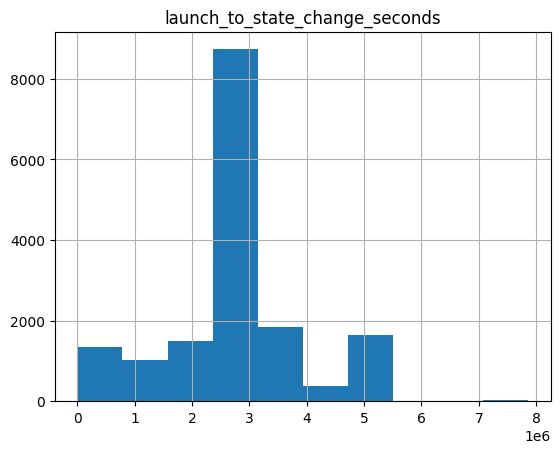

In [75]:
for col in X_train.columns:
    plt.figure()
    X_train[col].hist()
    plt.title(col)


In [76]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

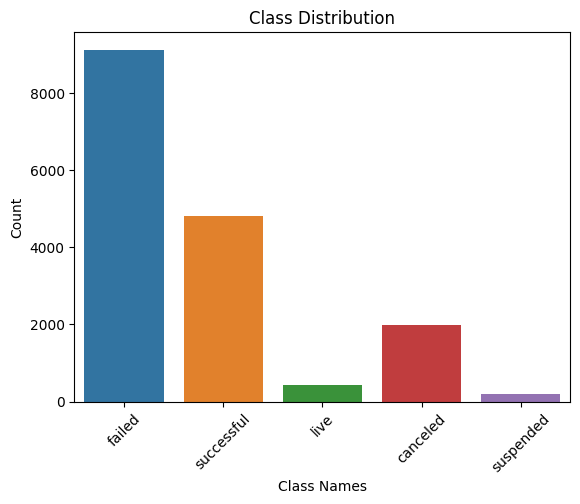

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary to map the encoded labels back to the original class names
label_mapping = {index: class_name for index, class_name in enumerate(le.classes_)}

# Map the encoded labels in y_train back to the original class names
y_train_names = pd.Series(y_train).map(label_mapping)

sns.countplot(x=y_train_names)
plt.title("Class Distribution")
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.show()


In [78]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [79]:
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# Fit the model on the training data
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the training and test sets
y_pred_train = xgb_classifier.predict(X_train_resampled)
y_pred_test = xgb_classifier.predict(X_test)

# Calculate accuracy for each set
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print classification reports for both sets
print("Training Classification Report:")
print(classification_report(y_train_resampled, y_pred_train, target_names=['0', '1', '2', '3', '4']))
print("Training Accuracy:", accuracy_train)

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['0', '1', '2', '3', '4']))
print("Test Accuracy:", accuracy_test)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9120
           1       1.00      1.00      1.00      9120
           2       1.00      1.00      1.00      9120
           3       1.00      1.00      1.00      9120
           4       1.00      1.00      1.00      9120

    accuracy                           1.00     45600
   macro avg       1.00      1.00      1.00     45600
weighted avg       1.00      1.00      1.00     45600

Training Accuracy: 1.0

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       477
           1       1.00      1.00      1.00      2296
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00      1220
           4       0.90      0.59      0.71        44

    accuracy                           0.99      4127
   macro avg       0.97      0.91      0.94    

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [82]:
classifiers = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Support Vector Classifier", SVC(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42))
]

for name, classifier in classifiers:
    # Train the model
    classifier.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy:", accuracy)

    # Calculate classification report
    report = classification_report(y_test, y_pred, target_names=['0', '1', '2', '3', '4'])
    print(f"\n{name} Test Classification Report:")
    print(report)

Random Forest Accuracy: 0.9682578143930216

Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       477
           1       0.97      0.99      0.98      2296
           2       0.97      1.00      0.98        90
           3       1.00      1.00      1.00      1220
           4       1.00      0.14      0.24        44

    accuracy                           0.97      4127
   macro avg       0.96      0.79      0.81      4127
weighted avg       0.97      0.97      0.96      4127



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9609886115822631

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       477
           1       0.98      1.00      0.99      2296
           2       0.92      1.00      0.96        90
           3       1.00      1.00      1.00      1220
           4       0.20      0.55      0.29        44

    accuracy                           0.96      4127
   macro avg       0.81      0.85      0.81      4127
weighted avg       0.97      0.96      0.96      4127

Support Vector Classifier Accuracy: 0.9551732493336564

Support Vector Classifier Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       477
           1       0.95      1.00      0.97      2296
           2       0.92      0.94      0.93        90
           3       1.00      0.99      1.00      1220
           4       0.22      0.1

In [83]:
# Hyperparameter optimization
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'n_estimators': [100, 200, 500],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}


grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, random_state=42),
                           param_grid=param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
xgb_best = XGBClassifier(use_label_encoder=False, random_state=42, **best_params)
xgb_best.fit(X_train_resampled, y_train_resampled)

# Predict with the best model
y_pred_best = xgb_best.predict(X_test)

# Calculate accuracy and classification report for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy with best parameters:", accuracy_best)
report_best = classification_report(y_test, y_pred_best, target_names=['0', '1', '2', '3', '4'])
print("\nTest Classification Report with best parameters:")
print(report_best)

# Adjust the classification threshold
#We adjust the classification threshold for class 4 to balance precision and recall, as it has lower values compared to the other classes.
y_pred_prob = xgb_best.predict_proba(X_test)
thresholds = np.arange(0, 1, 0.05)
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (y_pred_prob[:, 4] > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adjusted, average='macro')
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best threshold for class 4:", best_threshold)

# Use this threshold to adjust the predicted probabilities
y_pred_adjusted = np.argmax(y_pred_prob, axis=1)
y_pred_adjusted[y_pred_prob[:, 4] > best_threshold] = 4

# Calculate the adjusted accuracy and classification report
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
print("Adjusted Test Accuracy:", accuracy_adjusted)
report_adjusted = classification_report(y_test, y_pred_adjusted, target_names=['0', '1', '2', '3', '4'])
print("\nAdjusted Test Classification Report:")
print(report_adjusted)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  24.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  50.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=  47.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=  48.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=0.5; total time= 2.1min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.0

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 1.0}
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  24.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  50.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.5; total time= 2.1min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7; total time=  24.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=  49.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  49.3s
[CV] END colsample_bytree=0.5, lea

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  25.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=  50.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.5; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1.0; total time= 1.9min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=0.7; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  35.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.5; total time= 1.2min
[CV] END colsample_bytree=0.5, learning_rate=0.0

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=  25.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=  50.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.5; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  23.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=  25.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  50.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=0.7; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.0

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  23.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  24.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=  49.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7; total time=  24.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.7; total time=  51.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=0.7; total time= 2.1min
[CV] END colsample_bytree=0.5, learning_rate=0.0

Accuracy with best parameters: 0.993700024230676

Test Classification Report with best parameters:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       477
           1       1.00      1.00      1.00      2296
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00      1220
           4       0.93      0.59      0.72        44

    accuracy                           0.99      4127
   macro avg       0.98      0.91      0.94      4127
weighted avg       0.99      0.99      0.99      4127

Best threshold for class 4: 0.0
Adjusted Test Accuracy: 0.010661497455779016

Adjusted Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       477
           1       0.00      0.00      0.00      2296
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00      1220
           4       0.01   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  24.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=  52.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  24.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=  23.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.7; total time=  49.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=0.5; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.0

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  25.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=1.0; total time=  51.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time= 2.0min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5; total time=  23.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=  23.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.7; total time=  48.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=0.5; total time= 2.1min
[CV] END colsample_bytree=0.5, learning_rate=0.0

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  24.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.5; total time=  52.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time= 2.1min
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.7; total time=  23.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=  48.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  48.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=500, subsample=1.0; total time= 2.1min
[CV] END colsample_bytree=0.5, learning_rate=0.0